In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage import io, color, filters


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
np.random.seed(123)

In [4]:
path = "C:/Users/44730/Dropbox/PC/Documents/Exeter/MTHM602/Algae_Image_Classification/algae_data_11"

In [5]:
## EXTRACTING IMAGES AND STORING LABELS

not_harmful_label = "not harmful"
harmful_label = "harmful"

images = []  # to store image data as numpy arrays
labels = []  # to store image labels (not harmful or harmful)
species = []  # to store species name if harmful
filenames = []

# Iterate over all subfolders in the path
for subdir in os.listdir(path):
    subdir_path = os.path.join(path, subdir)
    if os.path.isdir(subdir_path):
        label = harmful_label if subdir != "nontoxic" else not_harmful_label
        # Iterate over all image files in the subfolder
        for filename in os.listdir(subdir_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_path = os.path.join(subdir_path, filename)
                image = Image.open(image_path)
                # Convert image to numpy array and add to data list
                images.append(np.array(image))
                labels.append(label)
                species.append(subdir)
                filenames.append(subdir + "_" + filename.split('_')[1])
                
images_df = pd.DataFrame({'images': images, 'labels': labels, 'species': species, 'filenames': filenames})

In [6]:
# CHECKING FOR SHAPES OF THE DATAFRAME

# Create a temporary DataFrame with the shapes of the images
temp_df = images_df.copy()
temp_df['shape'] = temp_df['images'].apply(lambda img: img.shape)

# Group by 'labels', 'species', and 'shape', and compute the count for each group
shape_count_df = temp_df.groupby(['labels', 'species', 'shape']).size().reset_index(name='count')

# Sort the shape_count_df DataFrame by 'count' in descending order
sorted_shape_count_df = shape_count_df.sort_values(by='count', ascending=False)

# Adjust pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

# Display the sorted table
print(sorted_shape_count_df)



          labels        species           shape  count
178  not harmful       nontoxic   (256, 256, 3)   4647
0        harmful       Anabaena   (256, 256, 3)    150
107      harmful   Oscillatoria   (256, 256, 3)    150
39       harmful    Microcystis   (256, 256, 3)    150
16       harmful    Gymnodinium   (256, 256, 3)    150
91       harmful      Nodularia   (256, 256, 3)    103
106      harmful         Nostoc   (256, 256, 3)    100
14       harmful  Aphanizomenon   (256, 256, 3)     83
165      harmful    Skeletonema   (194, 259, 3)     40
19       harmful        Karenia   (183, 275, 3)     27
139      harmful   Prorocentrum   (225, 225, 3)     27
172      harmful    Skeletonema   (225, 225, 3)     21
102      harmful         Nostoc   (194, 259, 3)     18
54       harmful      Noctiluca   (194, 259, 3)     16
11       harmful  Aphanizomenon   (195, 259, 3)     16
24       harmful        Karenia   (200, 252, 3)     15
122      harmful   Prorocentrum   (194, 259, 3)     14
57       h

In [7]:
# CHECKING FOR IMAGES WITH other than 3 CHANNELS

for index, row in images_df.iterrows():
    img = row['images']
    if img.shape[2] != 3:
        print(f"Image {row['filenames']} with species {row['species']} has shape {img.shape}")



Image nontoxic_1807.jpg with species nontoxic has shape (256, 256, 4)
Image nontoxic_1863.jpg with species nontoxic has shape (256, 256, 4)
Image nontoxic_649.jpg with species nontoxic has shape (256, 256, 4)


In [8]:
# Filter the DataFrame to keep only images with 3 channels
images_df2 = images_df[images_df['images'].apply(lambda img: img.shape == (img.shape[0], img.shape[1], 3))]



In [9]:
images_df2.shape[0]

6297

In [10]:
# GREYSCALING, BINARISZING AND RESIZING IMAGES


import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from PIL import Image

# Function to convert an image to grayscale
def to_grayscale(img_array):
    return cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)

# Function to binarize an image using Otsu's method
def binarize(img_array):
    gray_img = to_grayscale(img_array)
    _, binary_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_img

def normalize_binary_image(binary_img):
    mean_intensity = np.mean(binary_img)
    
    if mean_intensity > 127:
        # Invert the image if the mean intensity is greater than the threshold
        normalized_image = cv2.bitwise_not(binary_img)
    else:
        normalized_image = binary_img.copy()
    
    return normalized_image

# Function to convert images to HSV
def to_hsv(img_array):
    return cv2.cvtColor(img_array, cv2.COLOR_RGB2HSV)

def resize_image(img_array, target_size, pad_value=0, single_channel=False):
    img = Image.fromarray(img_array)
    width, height = img.size

    # Return the original image if dimensions are already target_size x target_size
    if width == target_size and height == target_size:
        return img_array

    aspect_ratio = width / height

    if width > height:
        new_width = target_size
        new_height = int(target_size / aspect_ratio)
    else:
        new_height = target_size
        new_width = int(target_size * aspect_ratio)

    resized_img = img.resize((new_width, new_height), Image.LANCZOS)

    if single_channel:
        padded_img = Image.new('L', (target_size, target_size), color=pad_value)
    else:
        padded_img = Image.new('RGB', (target_size, target_size), color=(pad_value, pad_value, pad_value))

    paste_x = (target_size - new_width) // 2
    paste_y = (target_size - new_height) // 2

    padded_img.paste(resized_img, (paste_x, paste_y))

    return np.array(padded_img)




# Apply grayscale and binarization transformations to the original images
images_df3_rgb = images_df2.copy()
images_df3_gray = images_df2.copy()
images_df3_binary = images_df2.copy()
images_df3_norm_binary = images_df2.copy()
# Apply HSV transformation to the original images
images_df3_hsv = images_df2.copy()

images_df3_gray['images'] = images_df3_gray['images'].apply(lambda img: to_grayscale(img))
images_df3_binary['images'] = images_df3_binary['images'].apply(lambda img: binarize(img))
images_df3_hsv['images'] = images_df3_hsv['images'].apply(lambda img: to_hsv(img))
images_df3_norm_binary['images'] = images_df3_binary['images'].apply(lambda img: normalize_binary_image(img))


# Resize images in the DataFrames
images_df3_rgb['images'] = images_df3_rgb['images'].apply(lambda img: img if img.shape[:2] == (256, 256) else resize_image(img, 256, single_channel=False))
images_df3_hsv['images'] = images_df3_hsv['images'].apply(lambda img: img if img.shape[:2] == (256, 256) else resize_image(img, 256, single_channel=False))
images_df3_gray['images'] = images_df3_gray['images'].apply(lambda img: img if img.shape[:2] == (256, 256) else resize_image(img, 256, single_channel=True))
images_df3_binary['images'] = images_df3_binary['images'].apply(lambda img: img if img.shape[:2] == (256, 256) else resize_image(img, 256, single_channel=True))
images_df3_norm_binary['images'] = images_df3_norm_binary['images'].apply(lambda img: img if img.shape[:2] == (256, 256) else resize_image(img, 256, single_channel=True))


In [11]:
# TRAIN, TEST SPLIT

import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle




# Function to process DataFrame and perform train-test split
def process_dataframe(df):
    # Split the dataset into harmful and non-harmful samples
    harmful_df = df[df['labels'] == 'harmful']
    not_harmful_df = df[df['labels'] == 'not harmful']

    # Find the number of samples in the minority class
    min_samples = min(len(harmful_df), len(not_harmful_df))

    # Perform undersampling on the majority class
    harmful_df = harmful_df.sample(min_samples, random_state=42)
    not_harmful_df = not_harmful_df.sample(min_samples, random_state=42)

    # Combine the two DataFrames and shuffle the rows
    balanced_df = pd.concat([harmful_df, not_harmful_df])
    balanced_df = shuffle(balanced_df, random_state=42)

    # Create a new column 'stratify_col' by combining the 'labels' and 'species' columns
    balanced_df['stratify_col'] = balanced_df['labels'] + '_' + balanced_df['species']

    # Perform a 70-30 stratified split
    train_df, test_df = train_test_split(balanced_df, test_size=0.3, stratify=balanced_df['stratify_col'], random_state=42)

    # Drop the 'stratify_col' as it's no longer needed
    train_df = train_df.drop(columns=['stratify_col'])
    test_df = test_df.drop(columns=['stratify_col'])

    return train_df, test_df

# Perform train-test split for each transformed DataFrame
train_df_rgb, test_df_rgb = process_dataframe(images_df3_rgb)
train_df_hsv, test_df_hsv = process_dataframe(images_df3_hsv)  
train_df_gray, test_df_gray = process_dataframe(images_df3_gray)
train_df_binary, test_df_binary = process_dataframe(images_df3_binary)
train_df_norm_binary, test_df_norm_binary = process_dataframe(images_df3_norm_binary)



In [12]:
# def reduce_dataframe(df, sample_ratio=0.02):
#     reduced_df = df.sample(frac=sample_ratio, random_state=42)
#     return reduced_df

# # Reduce each transformed DataFrame to % of its original size
# train_df_rgb = reduce_dataframe(train_df_rgb)
# test_df_rgb = reduce_dataframe(test_df_rgb)

# train_df_hsv = reduce_dataframe(train_df_hsv)
# test_df_hsv = reduce_dataframe(test_df_hsv)

# train_df_gray = reduce_dataframe(train_df_gray)
# test_df_gray = reduce_dataframe(test_df_gray)

# train_df_binary = reduce_dataframe(train_df_binary)
# test_df_binary = reduce_dataframe(test_df_binary)

# train_df_norm_binary = reduce_dataframe(train_df_norm_binary)
# test_df_norm_binary = reduce_dataframe(test_df_norm_binary)


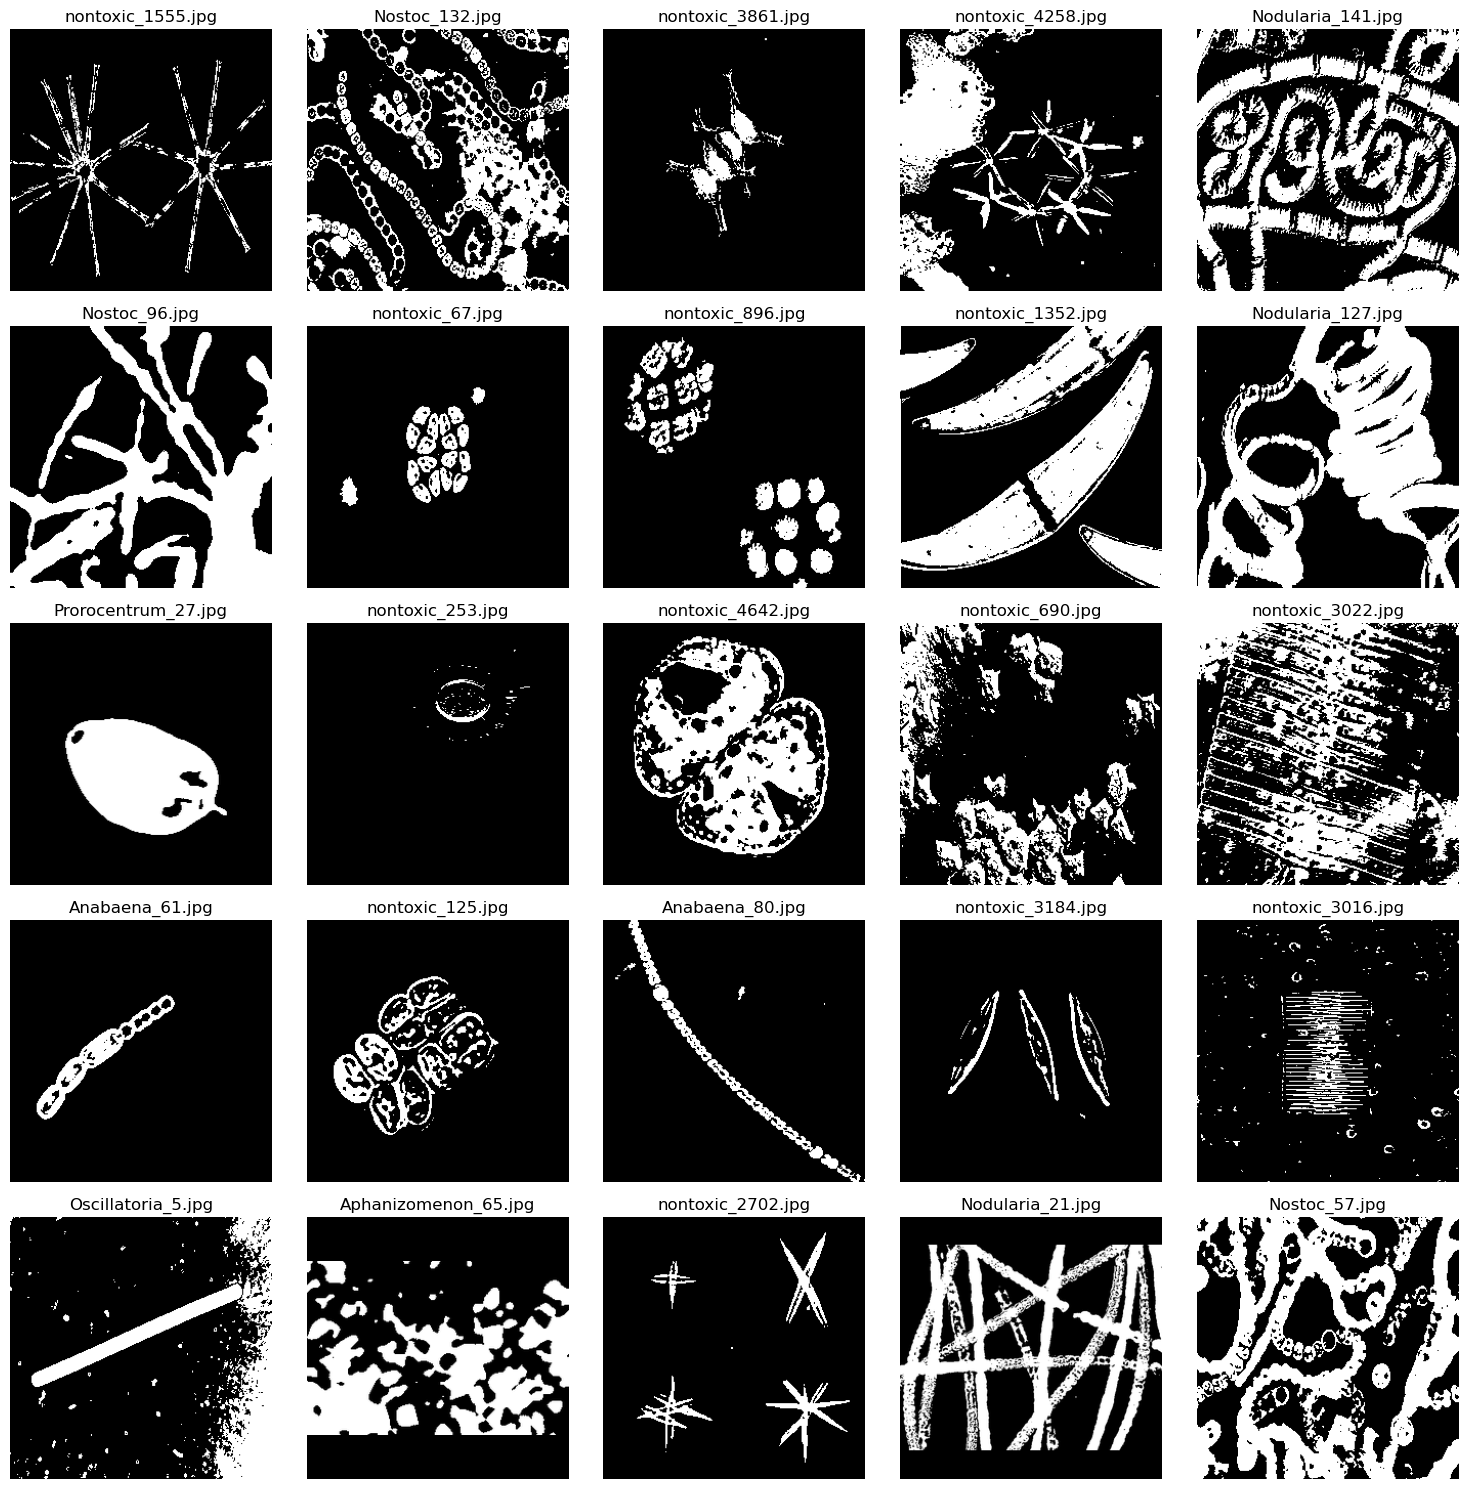

In [13]:
# CHECKING BINARISATION OUTCOME

import math
import matplotlib.pyplot as plt

def display_random_images(df, num_images=25, color_space='rgb'):
    random_indices = np.random.choice(len(df), num_images, replace=False)
    random_images = df.iloc[random_indices]['images'].tolist()
    random_labels = df.iloc[random_indices]['filenames'].tolist()

    num_cols = int(math.sqrt(num_images))
    num_rows = math.ceil(num_images / num_cols)

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(num_images):
        if color_space == 'hsv':
            # Convert the HSV image back to RGB before displaying
            rgb_image = cv2.cvtColor(random_images[i], cv2.COLOR_HSV2RGB)
            axes[i].imshow(rgb_image)
        elif color_space == 'gray':
            axes[i].imshow(random_images[i], cmap='gray')
        else:
            axes[i].imshow(random_images[i])

        axes[i].set_title(random_labels[i])
        axes[i].axis('off')
        

    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display random images from the HSV DataFrame
display_random_images(train_df_norm_binary, color_space='gray')


In [14]:
# DEFINING AND EXTRACTING HANDCRAFTED FEATURES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from skimage.feature import graycomatrix, graycoprops  # Update the import here
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import cv2
from sklearn.cluster import KMeans
from scipy.stats import skew
from skimage import measure
import numpy as np
import cv2
from scipy.special import factorial

# FIRST ORDER STATS

def calculate_statistics(image, input_string):
    # Calculate first-order statistics
    mean = np.mean(image)
    std = np.std(image)
    skewness = skew(image.flatten())
    kurt = kurtosis(image.flatten())

    # List of statistic names
    statistics = ['mean', 'std', 'skewness', 'kurtosis']
    values = [mean, std, skewness, kurt]

    # Define column headers with the input string
    headers = [f'{input_string}_{stat}' for stat in statistics]

    return values, headers

# HARALICK FEATURES

def calculate_haralick_features(image, input_string):
    # Check if the image is already in uint8 format
    if image.dtype != np.uint8:
        image = image.astype(np.uint8)

    # Calculate second-order statistics
    glcm = graycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    energy = graycoprops(glcm, 'energy').mean()
    contrast = graycoprops(glcm, 'contrast').mean()
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    correlation = graycoprops(glcm, 'correlation').mean()
    entropy = -np.sum(glcm * np.log2(glcm + 1e-6))

    # List of statistic names
    statistics = ['energy', 'contrast', 'homogeneity', 'correlation', 'entropy']
    values = [energy, contrast, homogeneity, correlation, entropy]

    # Define column headers with the input string
    headers = [f'{input_string}_{stat}' for stat in statistics]

    return values, headers

# LOG OF HU MOMENTS


def calculate_log_hu_moments(img_array, input_string):
    moments = cv2.moments(img_array)
    hu_moments = cv2.HuMoments(moments)
    log_hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))

    # Define column headers with the input string
    headers = [f'{input_string}_hu_moment_{i + 1}' for i in range(len(log_hu_moments))]

    return log_hu_moments.flatten(), headers

# ZERNIKE MOMENTS

def zernike_polynomial(x, y, n, m):
    radial = 0
    for s in range(int((n - abs(m)) / 2) + 1):
        coef = (-1)**s * factorial(n - s) / (factorial(s) * factorial((n + abs(m)) // 2 - s) * factorial((n - abs(m)) // 2 - s))
        radial += coef * (x**2 + y**2)**((n - 2 * s) / 2)
    azimuthal = np.cos(m * np.arctan2(y, x)) if m >= 0 else np.sin(abs(m) * np.arctan2(y, x))
    return radial * azimuthal

def calculate_zernike_moments(image, input_string, order=5):
    height, width = image.shape
    moments = []
    x = np.linspace(-1, 1, width)
    y = np.linspace(-1, 1, height)
    xv, yv = np.meshgrid(x, y)
    normalized_image = image / np.sum(image)

    for n in range(order + 1):
        for m in range(-n, n + 1, 2):
            zernike = zernike_polynomial(xv, yv, n, m)
            moment = np.sum(normalized_image * zernike)
            moments.append(moment)

    headers = [f'{input_string}_zernike_moment_{i + 1}' for i in range(len(moments))]
    return moments, headers

# COLOR MOMENTS

def color_moments(image, input_string):
    channels = cv2.split(image)
    moments = []
    headers = []
    for i, channel in enumerate(channels):
        mean = np.mean(channel)
        std = np.std(channel)
        skewness = skew(channel.ravel())
        kurt = kurtosis(channel.ravel())
        moments.extend([mean, std, skewness, kurt])
        headers.extend([f"{input_string}_channel_{i+1}_mean", f"{input_string}_channel_{i+1}_std", 
                        f"{input_string}_channel_{i+1}_skewness", f"{input_string}_channel_{i+1}_kurtosis"])
        
    return moments, headers


# EXTRACTING FEATURES

def extract_features(df, input_string, df_binary=None, df_norm_binary=None, df_rgb=None, df_hsv=None):
    feature_vectors = []
    statistics_headers = None
    haralick_headers = None
    log_hu_moments_headers = None
    log_hu_moments_headers_norm = None
    zernike_moments_headers = None
    zernike_moments_headers_norm = None
    cm_rgb_headers = None
    cm_hsv_headers = None


    for index, row in df.iterrows():
        image = row['images']
        label = row['labels']
        species = row['species']
        filename = row['filenames']

        # Extract features
        statistics, headers = calculate_statistics(image, input_string)
        if statistics_headers is None:
            statistics_headers = headers
            
        haralick_features, headers = calculate_haralick_features(image, f"{input_string}_haralick")
        if haralick_headers is None:
            haralick_headers = headers

        if df_binary is not None:
            binary_image = df_binary.loc[index, 'images']
            log_hu_moments, headers = calculate_log_hu_moments(binary_image, f"{input_string}_binary")
            if log_hu_moments_headers is None:
                log_hu_moments_headers = headers

            zernike_moments, headers = calculate_zernike_moments(binary_image, f"{input_string}_binary")
            if zernike_moments_headers is None:
                zernike_moments_headers = headers

        if df_norm_binary is not None:
            norm_binary_image = df_norm_binary.loc[index, 'images']
            log_hu_moments_norm, headers = calculate_log_hu_moments(norm_binary_image, f"{input_string}_norm_binary")
            if log_hu_moments_headers_norm is None:
                log_hu_moments_headers_norm = headers

            zernike_moments_norm, headers = calculate_zernike_moments(norm_binary_image, f"{input_string}_norm_binary")
            if zernike_moments_headers_norm is None:
                zernike_moments_headers_norm = headers

        if df_rgb is not None:
            rgb_image = df_rgb.loc[index, 'images']
            cm_rgb, cm_rgb_headers = color_moments(rgb_image, f"{input_string}_rgb")
            if cm_rgb_headers is None:
                cm_rgb_headers = headers

        if df_hsv is not None:
            hsv_image = df_hsv.loc[index, 'images']
            cm_hsv, cm_hsv_headers = color_moments(hsv_image, f"{input_string}_hsv")
            if cm_hsv_headers is None:
                cm_hsv_headers = headers




        # Create a feature vector with feature names
        feature_vector = [
            label,
            species,
            filename,
            *statistics,
            *haralick_features,
            *(log_hu_moments if df_binary is not None else []),
            *(log_hu_moments_norm if df_norm_binary is not None else []),
            *(zernike_moments if df_binary is not None else []),
            *(zernike_moments_norm if df_norm_binary is not None else []),
            *(cm_rgb if df_rgb is not None else []),
            *(cm_hsv if df_hsv is not None else []),
        ]

        feature_vectors.append(feature_vector)

        columns = [
            'label', 'species', 'filename',
            *statistics_headers,
            *haralick_headers,
            *(log_hu_moments_headers if df_binary is not None else []),
            *(log_hu_moments_headers_norm if df_norm_binary is not None else []),
            *(zernike_moments_headers if df_binary is not None else []),
            *(zernike_moments_headers_norm if df_norm_binary is not None else []),
            *(cm_rgb_headers if df_rgb is not None else []),
            *(cm_hsv_headers if df_hsv is not None else []),

        ]

    return pd.DataFrame(feature_vectors, columns=columns)


In [15]:
# EXTRACTING FEATURES FOR TRAIN DATA
train_df_all_features = extract_features(train_df_gray, 'F', df_binary=train_df_binary, df_norm_binary=train_df_norm_binary, df_rgb=train_df_rgb, df_hsv=train_df_hsv)


In [16]:
# CHECKING FOR EXTRACTION ERRORS

import pandas as pd

# Assuming features_train_df is already defined and contains data

# Check for NaN values in each row, get the rows with NaN values and count them
nan_rows = train_df_all_features.isnull().any(axis=1)
nan_rows_df = train_df_all_features[nan_rows]
num_rows_with_nan = nan_rows.sum()

# Display the DataFrame with NaN values and print the number of rows with NaN values
display(nan_rows_df)
print("Number of rows with NaN values:", num_rows_with_nan)



label    species           filename      F_mean       F_std  F_skewness  F_kurtosis  F_haralick_energy  F_haralick_contrast  F_haralick_homogeneity  F_haralick_correlation  F_haralick_entropy  F_binary_hu_moment_1  F_binary_hu_moment_2  F_binary_hu_moment_3  F_binary_hu_moment_4  F_binary_hu_moment_5  F_binary_hu_moment_6  F_binary_hu_moment_7  F_norm_binary_hu_moment_1  F_norm_binary_hu_moment_2  F_norm_binary_hu_moment_3  F_norm_binary_hu_moment_4  F_norm_binary_hu_moment_5  F_norm_binary_hu_moment_6  F_norm_binary_hu_moment_7  F_binary_zernike_moment_1  F_binary_zernike_moment_2  F_binary_zernike_moment_3  F_binary_zernike_moment_4  F_binary_zernike_moment_5  F_binary_zernike_moment_6  F_binary_zernike_moment_7  F_binary_zernike_moment_8  F_binary_zernike_moment_9  F_binary_zernike_moment_10  F_binary_zernike_moment_11  F_binary_zernike_moment_12  F_binary_zernike_moment_13  F_binary_zernike_moment_14  F_binary_zernike_moment_15  F_binary_zernike_moment_16  F_binary_zernike_moment_17  F_binary_zernike_moment_18  F_binary_zernike_moment_19  F_binary_zernike_moment_20  F_binary_zernike_moment_21  F_norm_binary_zernike_moment_1  F_norm_binary_zernike_moment_2  F_norm_binary_zernike_moment_3  F_norm_binary_zernike_moment_4  F_norm_binary_zernike_moment_5  F_norm_binary_zernike_moment_6  F_norm_binary_zernike_moment_7  F_norm_binary_zernike_moment_8  F_norm_binary_zernike_moment_9  F_norm_binary_zernike_moment_10  F_norm_binary_zernike_moment_11  F_norm_binary_zernike_moment_12  F_norm_binary_zernike_moment_13  F_norm_binary_zernike_moment_14  F_norm_binary_zernike_moment_15  F_norm_binary_zernike_moment_16  F_norm_binary_zernike_moment_17  F_norm_binary_zernike_moment_18  F_norm_binary_zernike_moment_19  F_norm_binary_zernike_moment_20  F_norm_binary_zernike_moment_21  F_rgb_channel_1_mean  F_rgb_channel_1_std  F_rgb_channel_1_skewness  F_rgb_channel_1_kurtosis  F_rgb_channel_2_mean  F_rgb_channel_2_std  F_rgb_channel_2_skewness  F_rgb_channel_2_kurtosis  F_rgb_channel_3_mean  F_rgb_channel_3_std  F_rgb_channel_3_skewness  F_rgb_channel_3_kurtosis  F_hsv_channel_1_mean  F_hsv_channel_1_std  F_hsv_channel_1_skewness  F_hsv_channel_1_kurtosis  F_hsv_channel_2_mean  F_hsv_channel_2_std  F_hsv_channel_2_skewness  F_hsv_channel_2_kurtosis  F_hsv_channel_3_mean  F_hsv_channel_3_std  F_hsv_channel_3_skewness  F_hsv_channel_3_kurtosis
52    not harmful   nontoxic  nontoxic_2962.jpg  144.245361   38.030112   -0.930817   -0.511568           0.141682           205.871896                0.292509                0.929058           36.649909              2.934827              7.975106             12.566169             12.131916             24.504515             16.194797            -24.974947                   2.952822                   6.644875                  12.269546                  11.788588                  23.824922                 -15.269015                 -24.559008                        1.0                   0.010892                  -0.004161                   0.006190                   0.629901                  -0.071993                   0.006481                  -0.012720                   0.000573                   -0.003084                    0.002649                   -0.000579                    1.155805                    0.018522                   -0.405001                    0.002562                   -0.010969                    0.008668                   -0.000572                    0.003019                    0.000070                             1.0                       -0.023377                        0.008931                       -0.013285                       -0.270268                        0.154515                       -0.013909                        0.027300                       -0.001229                         0.006619                        -0.005686                         0.001243                        -0.087277                        -0.039753                         0.016993                     

Number of rows with NaN values: 9


In [17]:
# REPLACING 9 IMAGES THAT HAVE NAN VALUES WITH MEAN

import pandas as pd


# Replace NaN values with the mean of the respective columns
train_df_all_features = train_df_all_features.fillna(train_df_all_features.mean(numeric_only=True))


In [18]:
# EXTRACTING FEATURES FOR TEST DATA
test_df_all_features = extract_features(test_df_gray, 'F', df_binary=test_df_binary, df_norm_binary=test_df_norm_binary, df_rgb=test_df_rgb, df_hsv=test_df_hsv)

In [19]:
# REPLACING NAN VALUES

test_df_all_features = test_df_all_features.fillna(test_df_all_features.mean(numeric_only=True))


In [20]:
# DEFINING FEATURE COLUMNS
feature_columns_all = [col for col in train_df_all_features.columns if col not in ['label', 'species', 'filename']]

In [21]:
# STANDARDISING AND NORMALISING TEST AND TRAIN EXTRACTED FEATURES BASED ON TRAIN DATA

from sklearn.preprocessing import StandardScaler, MinMaxScaler

def standardize_and_normalize_features(train_df, test_df=None):
    standard_scaler = StandardScaler()
    min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
    
    img_features_train = train_df[feature_columns_all]
    img_labels_train = train_df[['label', 'species', 'filename']]
    
    # Fit the standard scaler on the training set
    standard_scaler.fit(img_features_train)
    
    # Transform the training set using the standard scaler
    img_features_train_standardized = standard_scaler.transform(img_features_train)
    
    # Fit the min-max scaler on the standardized training set
    min_max_scaler.fit(img_features_train_standardized)
    
    # Transform the training set using the min-max scaler
    img_features_train_normalized = min_max_scaler.transform(img_features_train_standardized)
    
    # Combine the normalized features with 'label', 'species', and 'filename' columns
    train_df_normalized = pd.concat([img_labels_train.reset_index(drop=True), pd.DataFrame(img_features_train_normalized, columns=feature_columns_all)], axis=1)
    
    if test_df is not None:
        img_features_test = test_df[feature_columns_all]
        img_labels_test = test_df[['label', 'species', 'filename']]
        
        # Transform the test set using the fitted standard scaler
        img_features_test_standardized = standard_scaler.transform(img_features_test)
        
        # Transform the test set using the fitted min-max scaler
        img_features_test_normalized = min_max_scaler.transform(img_features_test_standardized)
        
        # Combine the normalized features with 'label', 'species', and 'filename' columns
        test_df_normalized = pd.concat([img_labels_test.reset_index(drop=True), pd.DataFrame(img_features_test_normalized, columns=feature_columns_all)], axis=1)
        return train_df_normalized, test_df_normalized
    
    return train_df_normalized

train_df_standardized_features, test_df_standardized_features = standardize_and_normalize_features(train_df_all_features, test_df_all_features)


In [22]:
# ANDERSON_DARLING TEST FOR NORMALITY

import pandas as pd
from scipy.stats import anderson

alpha = 0.05  # Significance level

# Initialize counts
normal_counts = {'not harmful': 0, 'harmful': 0}
non_normal_counts = {'not harmful': 0, 'harmful': 0}

# Store the results in a dictionary
results = {
    'Label': [],
    'Feature': [],
    'A-D Statistic': [],
    'Critical Value': [],
    'Significantly Different': []
}

# Separate the dataset by class
class_0_df = train_df_standardized_features[train_df_standardized_features['label'] == 'not harmful']
class_1_df = train_df_standardized_features[train_df_standardized_features['label'] == 'harmful']

for feature in feature_columns_all:
    for class_df, label in [(class_0_df, 'not harmful'), (class_1_df, 'harmful')]:
        result = anderson(class_df[feature], dist='norm')
        statistic = result.statistic
        critical_value_index = result.significance_level.tolist().index(5)  # Find the index of 5% significance level
        critical_value = result.critical_values[critical_value_index]  # Get the corresponding critical value

        results['Label'].append(label)
        results['Feature'].append(feature)
        results['A-D Statistic'].append(statistic)
        results['Critical Value'].append(critical_value)
        
        if statistic > critical_value:
            results['Significantly Different'].append(True)
            non_normal_counts[label] += 1
        else:
            results['Significantly Different'].append(False)
            normal_counts[label] += 1

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Create a dictionary with the counts
distribution_counts = {
    'Distribution': ['Normal', 'Non-normal'],
    'not harmful': [normal_counts['not harmful'], non_normal_counts['not harmful']],
    'harmful': [normal_counts['harmful'], non_normal_counts['harmful']]
}

# Convert the dictionary to a DataFrame
distribution_counts_df = pd.DataFrame(distribution_counts)

# Display the distribution counts DataFrame
print("Distribution Counts:")
print(distribution_counts_df)


Distribution Counts:
  Distribution  not harmful  harmful
0       Normal            1        2
1   Non-normal           88       87


In [23]:
# MANN-WHITNEY U TEST FOR FINDING SIGNIFICANT FEATURES

import pandas as pd
from scipy.stats import mannwhitneyu




mwu_results = {}

for feature in feature_columns_all:
    groups = [group[1][feature].values for group in train_df_standardized_features.groupby('label')]
    u_statistic, p_value = mannwhitneyu(groups[0], groups[1])
    mwu_results[feature] = {'U-Statistic': u_statistic, 'P-Value': p_value}

mwu_df = pd.DataFrame(mwu_results).T
mwu_df2 = mwu_df.sort_values(by='P-Value', ascending=True)

print(mwu_df2)


                                 U-Statistic        P-Value
F_hsv_channel_3_std                1049702.0  5.488778e-126
F_rgb_channel_2_std                1048124.0  5.754295e-125
F_std                              1045561.0  2.561934e-123
F_rgb_channel_1_std                1037124.0  5.716405e-118
F_hsv_channel_3_kurtosis            308557.0  8.886841e-111
F_rgb_channel_2_kurtosis            310720.0  1.811672e-109
F_kurtosis                          313378.0  7.181934e-108
F_rgb_channel_1_kurtosis            315837.0  2.109299e-106
F_binary_hu_moment_2                322589.0  2.005779e-102
F_rgb_channel_3_kurtosis            329742.0   2.708878e-98
F_rgb_channel_3_skewness            990764.0   1.008520e-90
F_binary_hu_moment_3                382720.0   2.183128e-70
F_rgb_channel_3_std                 936034.0   3.196929e-63
F_haralick_contrast                 931795.0   2.655502e-61
F_hsv_channel_2_kurtosis            412060.0   5.737016e-57
F_skewness                          9161

In [24]:
# CHECKING TOTAL NUMBER OF FEATURES
mwu_df2.shape

(89, 2)

In [25]:
# CREATING DATAFRAME KEEPING ONLY SIGNIFICANT FEATURES
import pandas as pd
from scipy.stats import mannwhitneyu

alpha = 0.05  # Significance level

# Assuming 'standardized_train_df' is the standardized DataFrame with features and 'label' is the class column
mwu_results = {}


# Filter the significant features based on the p-value
features_columns_significant = mwu_df[mwu_df['P-Value'] < alpha].index.tolist()

# Create new DataFrames with only significant features
train_df_significant_features = train_df_standardized_features[['label', 'species', 'filename'] + features_columns_significant]
test_df_significant_features = test_df_standardized_features[['label', 'species', 'filename'] + features_columns_significant]

train_df_significant_features.head()



label       species             filename    F_mean     F_std  F_skewness  F_kurtosis  F_haralick_energy  F_haralick_contrast  F_haralick_correlation  F_haralick_entropy  F_binary_hu_moment_1  F_binary_hu_moment_2  F_binary_hu_moment_3  F_binary_hu_moment_4  F_binary_hu_moment_5  F_binary_hu_moment_6  F_norm_binary_hu_moment_1  F_norm_binary_hu_moment_2  F_norm_binary_hu_moment_3  F_norm_binary_hu_moment_4  F_norm_binary_hu_moment_6  F_binary_zernike_moment_2  F_binary_zernike_moment_5  F_binary_zernike_moment_6  F_binary_zernike_moment_13  F_binary_zernike_moment_14  F_binary_zernike_moment_15  F_norm_binary_zernike_moment_5  F_norm_binary_zernike_moment_6  F_norm_binary_zernike_moment_13  F_norm_binary_zernike_moment_14  F_norm_binary_zernike_moment_15  F_norm_binary_zernike_moment_19  F_norm_binary_zernike_moment_20  F_rgb_channel_1_mean  F_rgb_channel_1_std  F_rgb_channel_1_skewness  F_rgb_channel_1_kurtosis  F_rgb_channel_2_mean  F_rgb_channel_2_std  F_rgb_channel_2_skewness  F_rgb_channel_2_kurtosis  F_rgb_channel_3_mean  F_rgb_channel_3_std  F_rgb_channel_3_skewness  F_rgb_channel_3_kurtosis  F_hsv_channel_1_mean  F_hsv_channel_1_std  F_hsv_channel_1_skewness  F_hsv_channel_1_kurtosis  F_hsv_channel_2_std  F_hsv_channel_2_skewness  F_hsv_channel_2_kurtosis  F_hsv_channel_3_mean  F_hsv_channel_3_std  F_hsv_channel_3_skewness  F_hsv_channel_3_kurtosis
0      harmful     Noctiluca     Noctiluca_65.jpg -0.973076 -0.590832    0.295537   -0.872633           0.153003            -0.900745                0.839644           -0.270681              0.176463             -0.515803             -0.501242             -0.548748             -0.448579              0.427197                   0.413464                   0.051968                   0.006066                  -0.254935                   0.487304                  -0.294808                  -0.563105                   0.117673                   -0.946134                    0.209386                    0.651971                       -0.538949                        0.088857                        -0.854720                         0.209386                         0.555336                         0.165194                        -0.084285             -0.969253            -0.730678                  0.296002                 -0.760084             -0.956188            -0.516195                  0.307817                 -0.907454             -0.866848            -0.452819                  0.321486                 -0.939820             -0.473218             0.226491                 -0.528565                 -0.999812             0.848436                 -0.583616                 -0.999937             -0.930838            -0.456363                  0.374999                 -0.940784
1      harmful   Skeletonema   Skeletonema_95.jpg -0.126565  0.990066    0.031977   -0.999817           0.149478            -0.498301                0.962082           -0.552459              0.843125             -0.474054              0.013367              0.416915              0.763391             -0.739921                   0.173088                  -0.510355                   0.007900                  -0.023985                   0.524549                  -0.083586                  -0.403402                  -0.441819                   -0.827122                    0.223054                    0.826222                       -0.404869                       -0.579441                        -0.690314                         0.338639                         0.691495                         0.089590                        -0.124437             -0.090135             0.985096                 -0.059959                 -0.999846             -0.129283             0.991790                  0.074362                 -0.999841             -0.119120             0.994301                  0.141712                 -0.999734             -0.722356            -0.064860                 -0.501820                 -0.998510            -0.64

In [60]:
# CHECKING NUMBER OF SIGNIFICANT FEATURES
len(features_columns_significant)

55

In [27]:
# CALCULATING FISCHERS DISCIMINIANT RATIOS TO RANK FEATURES

def fishers_discriminant_ratios(df, features, class_col):
    fdr_values = {}
    
    for feature in features:
        class_means = df.groupby(class_col)[feature].mean()
        class_variances = df.groupby(class_col)[feature].var()

        between_class_variance = ((class_means - df[feature].mean()) ** 2).sum()
        within_class_variance = class_variances.sum()

        fdr = between_class_variance / within_class_variance
        fdr_values[feature] = fdr
    
    return fdr_values

# FDR CALCS
fdr_values = fishers_discriminant_ratios(train_df_significant_features, features_columns_significant, 'label')

# To convert the FDR values into a sorted DataFrame
fdr_df = pd.DataFrame.from_dict(fdr_values, orient='index', columns=['FDR']).sort_values(by='FDR', ascending=False)

fdr_df

FDR
F_hsv_channel_3_std              0.352359
F_rgb_channel_2_std              0.344469
F_std                            0.333627
F_rgb_channel_1_std              0.309227
F_binary_hu_moment_2             0.196657
F_rgb_channel_3_std              0.147999
F_rgb_channel_3_skewness         0.147819
F_binary_hu_moment_3             0.117584
F_binary_zernike_moment_13       0.108575
F_hsv_channel_3_mean             0.098040
F_haralick_contrast              0.094446
F_binary_zernike_moment_6        0.092996
F_rgb_channel_3_mean             0.092977
F_rgb_channel_2_mean             0.091330
F_mean                           0.085992
F_binary_zernike_moment_15       0.084912
F_rgb_channel_3_kurtosis         0.081453
F_kurtosis                       0.079902
F_hsv_channel_3_kurtosis         0.078108
F_rgb_channel_2_kurtosis         0.077491
F_hsv_channel_3_skewness         0.077471
F_skewness                       0.075800
F_haralick_correlation           0.071093
F_rgb_channel_1_kurtosis         0.071088
F_binary_hu_moment_4             0.070545
F_hsv_channel_1_std              0.065449
F_rgb_channel_1_mean             0.057111
F_rgb_channel_2_skewness         0.056629
F_hsv_channel_2_skewness         0.055020
F_binary_zernike_moment_5        0.053008
F_rgb_channel_1_skewness         0.052067
F_norm_binary_zernike_moment_5   0.046834
F_hsv_channel_1_mean             0.044500
F_binary_zernike_moment_14       0.043056
F_hsv_channel_2_std              0.022678
F_binary_hu_moment_1             0.018046
F_hsv_channel_1_kurtosis         0.016456
F_norm_binary_hu_moment_1        0.013457
F_norm_binary_zernike_moment_14  0.012880
F_norm_binary_zernike_moment_6   0.010521
F_norm_binary_zernike_moment_15  0.008685
F_haralick_entropy               0.007691
F_norm_binary_hu_moment_2        0.007452
F_binary_hu_moment_6             0.007385
F_hsv_channel_2_kurtosis         0.007051
F_norm_binary_hu_moment_3        0.005939
F_hsv_channel_1_skewness         0.004391
F_haralick_energy                0.003635
F_norm_binary_hu_moment_4        0.003491
F_norm_binary_hu_moment_6        0.001838
F_binary_hu_moment_5             0.001773
F_norm_binary_zernike_moment_19  0.001697
F_norm_binary_zernike_moment_20  0.001624
F_norm_binary_zernike_moment_13  0.001510
F_binary_zernike_moment_2        0.000195

In [28]:
# TAKING TOP 12 FEATURS FOR CORRELATION ANALYSIS

# Filter features with FDR score over 0.04
#features_columns_fdr_filtered = fdr_df[fdr_df['FDR'] > 0.07].index.tolist()


# Assign the list of top 16 feature columns to a new variable
features_columns_fdr_top_12 = fdr_df.head(12).index.tolist()



In [29]:
features_columns_fdr_top_12

['F_hsv_channel_3_std',
 'F_rgb_channel_2_std',
 'F_std',
 'F_rgb_channel_1_std',
 'F_binary_hu_moment_2',
 'F_rgb_channel_3_std',
 'F_rgb_channel_3_skewness',
 'F_binary_hu_moment_3',
 'F_binary_zernike_moment_13',
 'F_hsv_channel_3_mean',
 'F_haralick_contrast',
 'F_binary_zernike_moment_6']

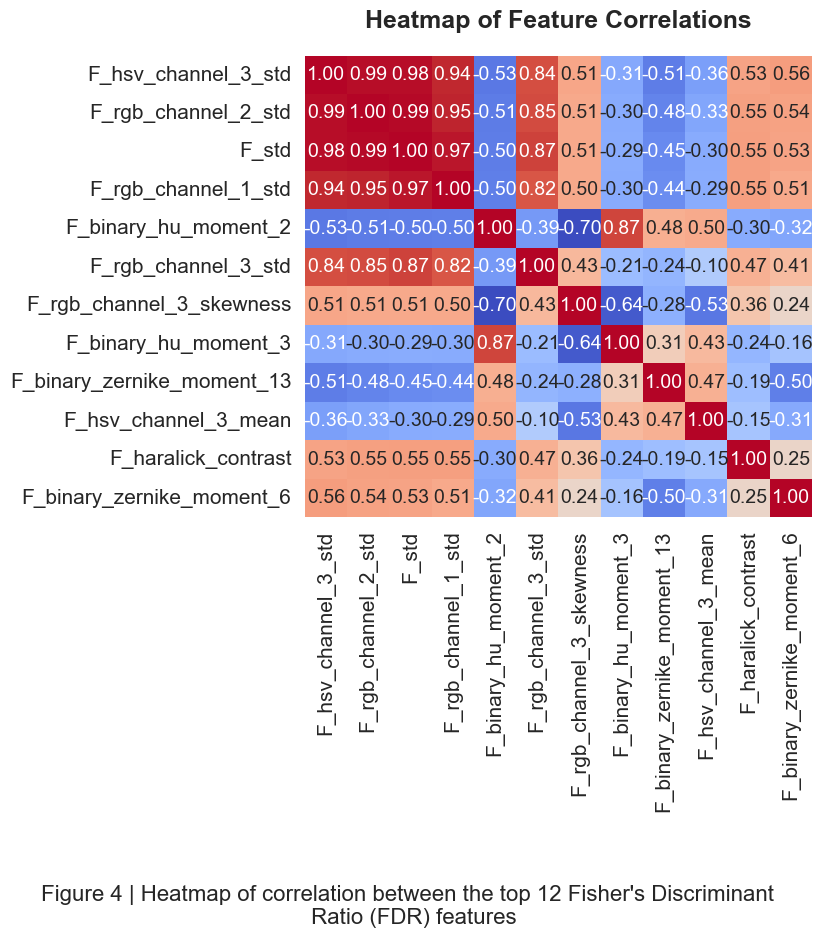

In [66]:
# CREATING CORRELATION MATRIX

# 5) Compute the correlation matrix and create a heatmap
corr = train_df_significant_features[features_columns_fdr_top_12].corr()

# Set the default font size
plt.rcParams.update({'font.size': 16})

# Set the figure size
plt.figure(figsize=(8.5, 8.5))

# Create the heatmap with custom annotation font size
ax = sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', cbar=False, annot_kws={'size': 14})

# Add title
plt.title("Heatmap of Feature Correlations", fontsize=18, fontweight='bold', pad=20)

# Add caption
caption = "Figure 4 | Heatmap of correlation between the top 12 Fisher's Discriminant \n Ratio (FDR) features"
plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=16)

# Update x and y axis label font size
ax.set_xticklabels(ax.get_xticklabels(), fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)

plt.subplots_adjust(bottom=0.35)

# Save the plot as a PNG file
plt.savefig('heatmap_of_feature_correlations2.png', dpi=300, bbox_inches='tight')

# Show plot with adjusted layout
plt.tight_layout()
plt.show()


In [31]:
# CRAETING SUBSET OF TOP 20 FDR FEATURES
features_columns_fdr_filtered = fdr_df.head(20).index.tolist()

In [32]:
features_columns_fdr_filtered

['F_hsv_channel_3_std',
 'F_rgb_channel_2_std',
 'F_std',
 'F_rgb_channel_1_std',
 'F_binary_hu_moment_2',
 'F_rgb_channel_3_std',
 'F_rgb_channel_3_skewness',
 'F_binary_hu_moment_3',
 'F_binary_zernike_moment_13',
 'F_hsv_channel_3_mean',
 'F_haralick_contrast',
 'F_binary_zernike_moment_6',
 'F_rgb_channel_3_mean',
 'F_rgb_channel_2_mean',
 'F_mean',
 'F_binary_zernike_moment_15',
 'F_rgb_channel_3_kurtosis',
 'F_kurtosis',
 'F_hsv_channel_3_kurtosis',
 'F_rgb_channel_2_kurtosis']

In [33]:
## RERANKING TOP 20 FDR USING MRMR

import numpy as np
import pandas as pd
from pyitlib import discrete_random_variable as drv
import itertools
from sklearn.preprocessing import LabelEncoder

def mrmr_score(X, y, selected_features):
    relevance = np.mean([drv.information_mutual(X[:, i], y) for i in selected_features])
    if len(selected_features) <= 1:
        redundancy = 0
    else:
        redundancy = np.mean([drv.information_mutual(X[:, i], X[:, j]) for i, j in itertools.combinations(selected_features, 2)])
    return relevance - redundancy

def mrmr_find_best_features(X, y, num_features):
    selected_features = []
    remaining_features = list(range(X.shape[1]))

    for _ in range(num_features):
        best_score = -np.inf
        best_feature = None

        for feature in remaining_features:
            current_features = selected_features + [feature]
            score = mrmr_score(X, y, current_features)

            if score > best_score:
                best_score = score
                best_feature = feature

        selected_features.append(best_feature)
        remaining_features.remove(best_feature)

    return selected_features, best_score

train_df_for_mrmr = train_df_significant_features[features_columns_fdr_filtered + ['label']]

# Convert target variable to binary and store as a numpy array
encoder = LabelEncoder()
target = encoder.fit_transform(train_df_for_mrmr['label']).astype(np.int32)

# Convert categorical variables to one-hot encoded variables and multiply by 1000
X = pd.get_dummies(train_df_for_mrmr[features_columns_fdr_filtered], drop_first=True)
X = (X * 100).astype(np.int32)
X = X.values

# List of different numbers of features to select
num_features_list = [2,3,4,6,9,13]

# Find the best features for each feature set size
results = {}
for num_features in num_features_list:
    best_features, best_score = mrmr_find_best_features(X, target, num_features)
    results[num_features] = {'selected_features': best_features, 'mrmr_score': best_score}

# Initialize an empty dictionary to store the feature lists
feature_columns_mrmr = {}

# Process the results and display the feature ranking and mRMR score for each feature set size
for num_features, result in results.items():
    selected_features = result['selected_features']
    mrmr_score = result['mrmr_score']
    feature_ranks = pd.DataFrame({'Feature': [features_columns_fdr_filtered[i] for i in selected_features], 'Rank': range(1, len(selected_features) + 1)})

    # Print the feature ranking and mRMR score
    print(f"Feature ranking for {num_features} features (mRMR score: {mrmr_score}):")
    print(feature_ranks.to_string(index=False))
    print("\n")

    # Save the feature list to the dictionary
    list_name = f"features_columns_mrmr_{num_features}f"
    feature_columns_mrmr[list_name] = [features_columns_fdr_filtered[i] for i in selected_features]

# Access the feature lists using the generated variable names
features_columns_mrmr_2f = feature_columns_mrmr["features_columns_mrmr_2f"]
features_columns_mrmr_3f = feature_columns_mrmr["features_columns_mrmr_3f"]
features_columns_mrmr_4f = feature_columns_mrmr["features_columns_mrmr_4f"]
features_columns_mrmr_6f = feature_columns_mrmr["features_columns_mrmr_6f"]
features_columns_mrmr_9f = feature_columns_mrmr["features_columns_mrmr_9f"]
features_columns_mrmr_13f = feature_columns_mrmr["features_columns_mrmr_13f"]
#features_columns_mrmr_19f = feature_columns_mrmr["features_columns_mrmr_19f"]



Feature ranking for 2 features (mRMR score: -1.261520073189284):
                 Feature  Rank
     F_rgb_channel_2_std     1
F_rgb_channel_3_kurtosis     2


Feature ranking for 3 features (mRMR score: -1.245592853474431):
                  Feature  Rank
      F_rgb_channel_2_std     1
 F_rgb_channel_3_kurtosis     2
F_binary_zernike_moment_6     3


Feature ranking for 4 features (mRMR score: -1.252329913707315):
                  Feature  Rank
      F_rgb_channel_2_std     1
 F_rgb_channel_3_kurtosis     2
F_binary_zernike_moment_6     3
 F_hsv_channel_3_kurtosis     4


Feature ranking for 6 features (mRMR score: -1.2454794461707446):
                   Feature  Rank
       F_rgb_channel_2_std     1
  F_rgb_channel_3_kurtosis     2
 F_binary_zernike_moment_6     3
  F_hsv_channel_3_kurtosis     4
       F_haralick_contrast     5
F_binary_zernike_moment_13     6


Feature ranking for 9 features (mRMR score: -1.4274610598108906):
                   Feature  Rank
       F_rgb_channel

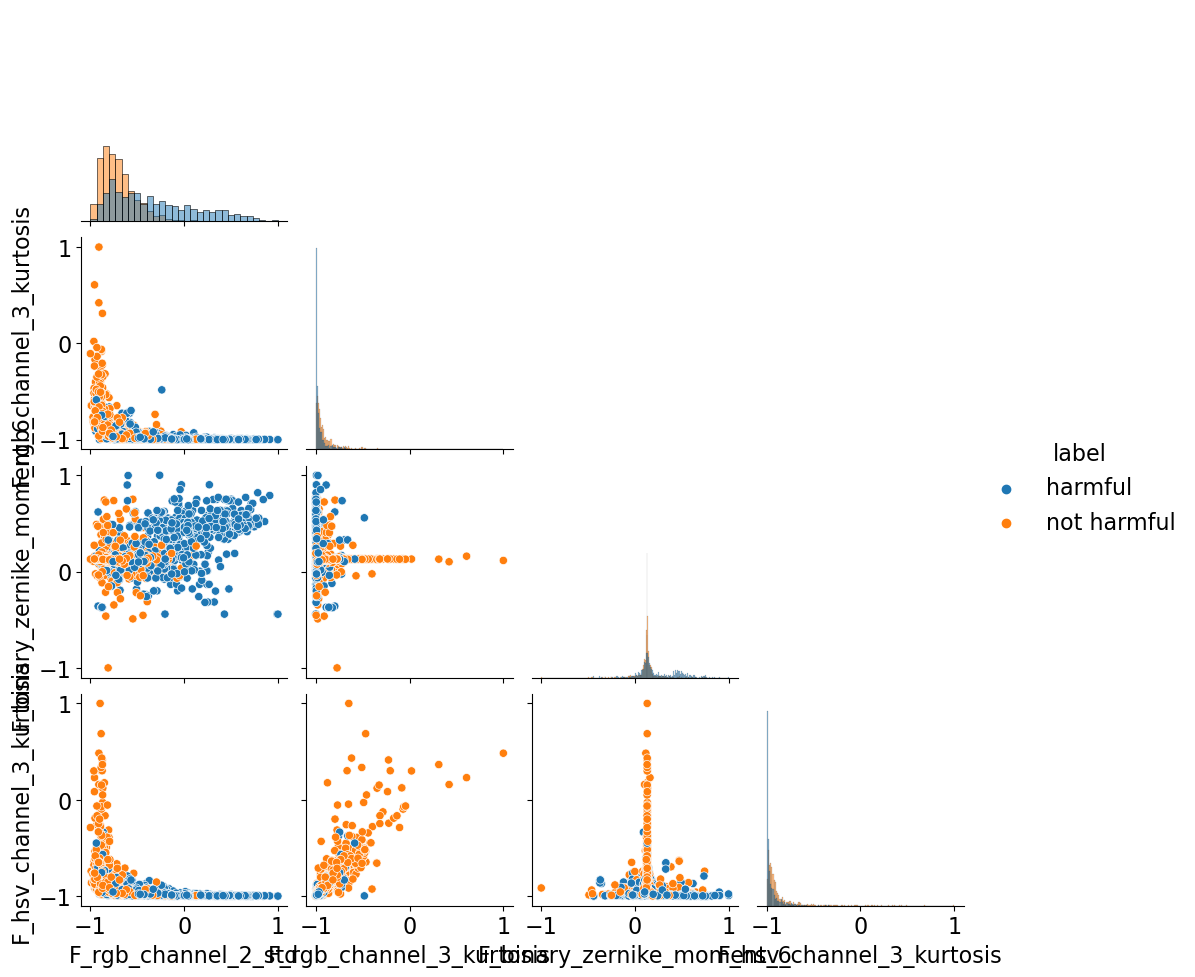

In [34]:
# SCATTER PLOTS TO VIEW CORRELATIONS BY CLASS


sns.pairplot(train_df_significant_features[features_columns_mrmr_4f + ['label']], diag_kind='hist', hue='label', corner=True)
plt.show()

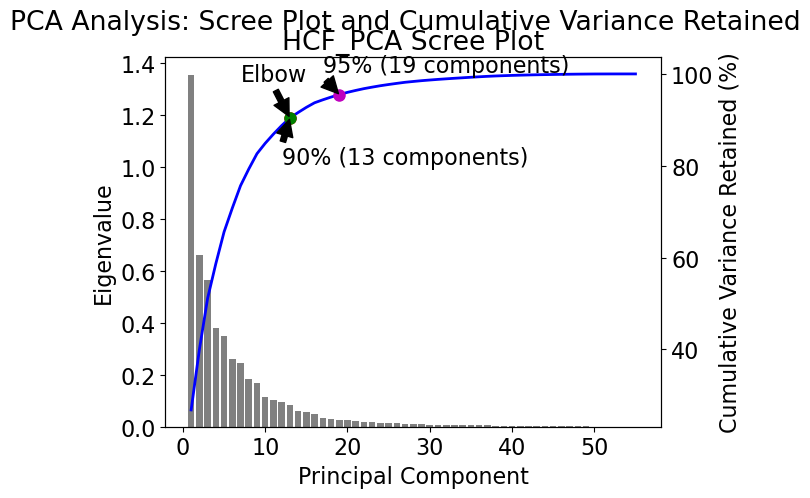

In [37]:
# USING PCA FOR FEATURE SPACE REDUCTION OF ALL SIGNIFICANT FEATURES

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Extract only the feature columns
train_data_for_hcf_pca = train_df_significant_features.drop(columns=['label', 'species', 'filename'])
test_data_for_hcf_pca = test_df_significant_features.drop(columns=['label', 'species', 'filename'])

# Perform HCF_PCA
hcf_pca = PCA()
train_hcf_pca = hcf_pca.fit_transform(train_data_for_hcf_pca)
explained_variance_ratio = hcf_pca.explained_variance_ratio_
# Project the test data onto the HCF_PCA components
test_hcf_pca = hcf_pca.transform(test_data_for_hcf_pca)

# Calculate cumulative variance explained ratio
cumulative_explained = np.cumsum(explained_variance_ratio)

# Find the elbow point
def find_elbow_point(cumulative_explained):
    num_points = len(cumulative_explained)
    first_point = np.array([1, cumulative_explained[0]])
    last_point = np.array([num_points, cumulative_explained[-1]])
    line_vec = last_point - first_point

    distances = np.zeros(num_points)
    for i in range(num_points):
        point = np.array([i + 1, cumulative_explained[i]])
        point_vec = point - first_point
        line_proj = np.dot(point_vec, line_vec) / np.dot(line_vec, line_vec) * line_vec
        dist_vec = point_vec - line_proj
        distances[i] = np.linalg.norm(dist_vec)

    elbow_point = np.argmax(distances) + 1
    return elbow_point

elbow_point = find_elbow_point(cumulative_explained)
point_90 = np.argmax(cumulative_explained >= 0.9) + 1
point_95 = np.argmax(cumulative_explained >= 0.95) + 1

# Create the combined plot
fig, ax1 = plt.subplots()

# Left y-axis: Eigenvalues as bars
ax1.bar(range(1, len(hcf_pca.explained_variance_) + 1), hcf_pca.explained_variance_, color='gray')
ax1.set_ylabel('Eigenvalue')

# Right y-axis: Cumulative variance explained ratio as a line
ax2 = ax1.twinx()
ax2.plot(range(1, len(cumulative_explained) + 1), cumulative_explained * 100, 'b-', linewidth=2)
ax2.set_ylabel('Cumulative Proportion of Variance Retained (%)')

ax1.set_xlabel('Principal Component')
ax1.set_title('HCF_PCA Scree Plot and Cumulative Variance Retained')


# Mark the elbow point on the plot
ax2.plot(elbow_point, cumulative_explained[elbow_point - 1] * 100, 'ro', markersize=8, linewidth=2)
ax2.annotate(f'Elbow', xy=(elbow_point, cumulative_explained[elbow_point - 1] * 100),
             xytext=(elbow_point - 6, cumulative_explained[elbow_point - 1] * 100 + 8),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Mark and annotate the points that explain 90% and 95% of the variance
ax2.plot(point_90, cumulative_explained[point_90 - 1] * 100, 'go', markersize=8, linewidth=2)
ax2.annotate(f'90% ({point_90} components)', xy=(point_90, cumulative_explained[point_90 - 1] * 100),
xytext=(point_90 - 1, cumulative_explained[point_90 - 1] * 100 - 10),
arrowprops=dict(facecolor='black', shrink=0.05))

ax2.plot(point_95, cumulative_explained[point_95 - 1] * 100, 'mo', markersize=8, linewidth=2)
ax2.annotate(f'95% ({point_95} components)', xy=(point_95, cumulative_explained[point_95 - 1] * 100),
xytext=(point_95 - 2, cumulative_explained[point_95 - 1] * 100 + 5),
arrowprops=dict(facecolor='black', shrink=0.05))

ax1.set_xlabel('Principal Component')
ax1.set_title('HCF_PCA Scree Plot')
ax1.set_ylabel('Eigenvalue')

ax2.set_ylabel('Cumulative Variance Retained (%)')
fig.suptitle('PCA Analysis: Scree Plot and Cumulative Variance Retained')

plt.show()


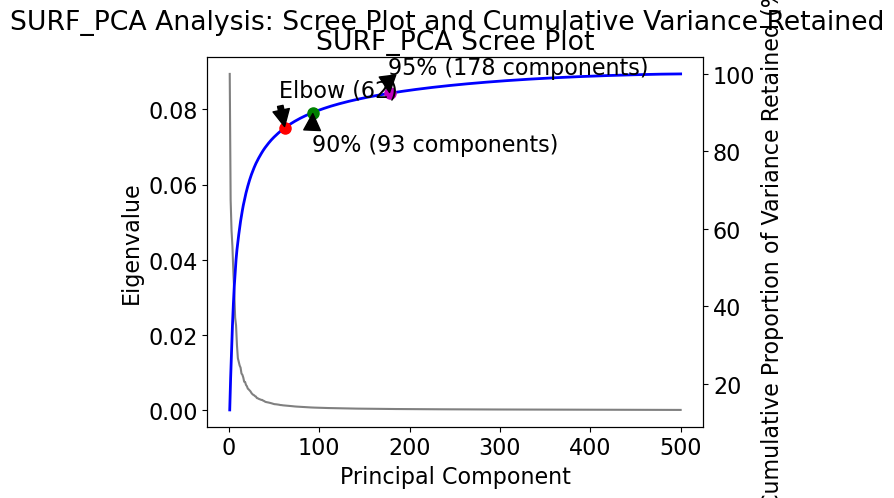

In [38]:
# NOTE: SURF FEATURES WAS CALCUALTED ON MATLBAB AND WAS AN ALTERNATIVE FEATURE EXTRACTION METHOD EXPLORED.
# THE SURF FEATURES ARE IMPORTED HERE FOR COMPARISON WITH HANDCRAFTED FEATURES MODELS
# PCA ALSO USED ON SURF

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# SURF PCA 1


predTable_train = pd.read_csv('predTable_train.csv')
predTable_test = pd.read_csv('predTable_test.csv')


# Assuming train_df_significant_features and test_df_significant_features are already defined
# Extract only the feature columns
train_data_for_surf_pca = predTable_train.drop(columns=['label', 'species', 'filename'])
test_data_for_surf_pca = predTable_test.drop(columns=['label', 'species', 'filename'])

# Perform SURF_PCA
surf_pca = PCA()
train_surf_pca = surf_pca.fit_transform(train_data_for_surf_pca)
explained_variance_ratio = surf_pca.explained_variance_ratio_
# Project the test data onto the SURF_PCA components
test_surf_pca = surf_pca.transform(test_data_for_surf_pca)

# Calculate cumulative variance explained ratio
cumulative_explained = np.cumsum(explained_variance_ratio)

# Find the elbow point
def find_elbow_point(cumulative_explained):
    num_points = len(cumulative_explained)
    first_point = np.array([1, cumulative_explained[0]])
    last_point = np.array([num_points, cumulative_explained[-1]])
    line_vec = last_point - first_point

    distances = np.zeros(num_points)
    for i in range(num_points):
        point = np.array([i + 1, cumulative_explained[i]])
        point_vec = point - first_point
        line_proj = np.dot(point_vec, line_vec) / np.dot(line_vec, line_vec) * line_vec
        dist_vec = point_vec - line_proj
        distances[i] = np.linalg.norm(dist_vec)

    elbow_point = np.argmax(distances) + 1
    return elbow_point

elbow_point = find_elbow_point(cumulative_explained)
point_90 = np.argmax(cumulative_explained >= 0.9) + 1
point_95 = np.argmax(cumulative_explained >= 0.95) + 1

# Create the combined plot
fig, ax1 = plt.subplots()

# Left y-axis: Eigenvalues as bars
ax1.plot(range(1, len(surf_pca.explained_variance_) + 1), surf_pca.explained_variance_, color='gray')
ax1.set_ylabel('Eigenvalue')

# Right y-axis: Cumulative variance explained ratio as a line
ax2 = ax1.twinx()
ax2.plot(range(1, len(cumulative_explained) + 1), cumulative_explained * 100, 'b-', linewidth=2)
ax2.set_ylabel('Cumulative Proportion of Variance Retained (%)')

ax1.set_xlabel('Principal Component')
ax1.set_title('SURF_PCA Scree Plot and Cumulative Variance Retained')


# Mark the elbow point on the plot
ax2.plot(elbow_point, cumulative_explained[elbow_point - 1] * 100, 'ro', markersize=8, linewidth=2)
ax2.annotate(f'Elbow ({elbow_point})', xy=(elbow_point, cumulative_explained[elbow_point - 1] * 100),
             xytext=(elbow_point - 6, cumulative_explained[elbow_point - 1] * 100 + 8),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Mark and annotate the points that explain 90% and 95% of the variance
ax2.plot(point_90, cumulative_explained[point_90 - 1] * 100, 'go', markersize=8, linewidth=2)
ax2.annotate(f'90% ({point_90} components)', xy=(point_90, cumulative_explained[point_90 - 1] * 100),
xytext=(point_90 - 1, cumulative_explained[point_90 - 1] * 100 - 10),
arrowprops=dict(facecolor='black', shrink=0.05))

ax2.plot(point_95, cumulative_explained[point_95 - 1] * 100, 'mo', markersize=8, linewidth=2)
ax2.annotate(f'95% ({point_95} components)', xy=(point_95, cumulative_explained[point_95 - 1] * 100),
xytext=(point_95 - 2, cumulative_explained[point_95 - 1] * 100 + 5),
arrowprops=dict(facecolor='black', shrink=0.05))

ax1.set_xlabel('Principal Component')
ax1.set_title('SURF_PCA Scree Plot')
ax1.set_ylabel('Eigenvalue')

ax2.set_ylabel('Cumulative Proportion of Variance Retained (%)')
fig.suptitle('SURF_PCA Analysis: Scree Plot and Cumulative Variance Retained')

plt.show()


In [39]:
# GETING DIFFERNT SUBSETS OF HANDCRAFTED FEATURES PCA REDUCED COMPONENTS READY FOR SVM CLASSIFIERS

# Create a list of PCA component counts
hcf_component_counts = [2, 3, 4, 6, 9, 13, 19]

# Initialize lists to store column names for each PCA component count
hcf_pca_columns = {count: [f'HCF_PCA_{i + 1}' for i in range(count)] for count in hcf_component_counts}

# Initialize dictionaries to store train and test DataFrames for each PCA component count
train_df_hcf_pca = {}
test_df_hcf_pca = {}

for count in hcf_component_counts:
    # Extract PCA component scores for train data
    train_hcf_pca_count = train_hcf_pca[:, :count]

    # Create train DataFrame for this component count
    train_df_hcf_pca[count] = pd.DataFrame(train_hcf_pca_count, columns=hcf_pca_columns[count])
    train_df_hcf_pca[count][['label', 'species', 'filename']] = train_df_significant_features[['label', 'species', 'filename']]

    # Extract PCA component scores for test data
    test_hcf_pca_count = test_hcf_pca[:, :count]

    # Create test DataFrame for this component count
    test_df_hcf_pca[count] = pd.DataFrame(test_hcf_pca_count, columns=hcf_pca_columns[count])
    test_df_hcf_pca[count][['label', 'species', 'filename']] = test_df_significant_features[['label', 'species', 'filename']]



In [40]:
# GETTING DIFFERNT SUBSETS OF SURF FEATURES PCA REDUCED COMPONENTS READY FOR SVM CLASSIFIERS

# Create a list of PCA component counts
surf_component_counts = [2, 3, 4, 6, 9, 62, 93, 178]

# Initialize lists to store column names for each PCA component count
surf_pca_columns = {count: [f'SURF_PCA_{i + 1}' for i in range(count)] for count in surf_component_counts}

# Initialize dictionaries to store train and test DataFrames for each PCA component count
train_df_surf_pca = {}
test_df_surf_pca = {}

for count in surf_component_counts:
    # Extract PCA component scores for train data
    train_surf_pca_count = train_surf_pca[:, :count]

    # Create train DataFrame for this component count
    train_df_surf_pca[count] = pd.DataFrame(train_surf_pca_count, columns=surf_pca_columns[count])
    train_df_surf_pca[count][['label', 'species', 'filename']] = predTable_train[['label', 'species', 'filename']]

    # Extract PCA component scores for test data
    test_surf_pca_count = test_surf_pca[:, :count]

    # Create test DataFrame for this component count
    test_df_surf_pca[count] = pd.DataFrame(test_surf_pca_count, columns=surf_pca_columns[count])
    test_df_surf_pca[count][['label', 'species', 'filename']] = predTable_test[['label', 'species', 'filename']]



In [41]:
# HANDSELECTED 3 FEATURE SUBSET TO GET A TOP FDR FEATURE FROM EVERY VISUAL CATEGORY (SHAPE, TEXTURE, COLOR)
features_columns_hp_3f = ['F_rgb_channel_2_std', 'F_binary_zernike_moment_6', 'F_haralick_contrast']


In [42]:
# Using cross-validation to find the best SVM kernel and hyperparameters to be used
# for final models for each respective feature subset

# PLEASE NOTE WHILE THERE ARE 55 SIGNIFICANT FEATURES SOME VARIABLES HAVE BEEN INCORRECTLY NAMED INDICATING THERE ARE 58

import optuna
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, recall_score
from optuna.pruners import MedianPruner
import time




feature_columns_lists = {
    'mrmr_2f': features_columns_mrmr_2f,
    'mrmr_3f': features_columns_mrmr_3f,
    'hp_3f': features_columns_hp_3f,
    'mrmr_4f': features_columns_mrmr_4f,
    'mrmr_6f': features_columns_mrmr_6f,
    'mrmr_9f': features_columns_mrmr_9f,
    'mrmr_13f': features_columns_mrmr_13f,
    'fdr_filtered_20f': features_columns_fdr_filtered,
    'significant_58f': features_columns_significant,
}

# Add the HCF_PCA and SURF_PCA feature columns to the feature_columns_lists dictionary
for count in hcf_component_counts:
    feature_columns_lists[f'hcf_pca_{count}c'] = hcf_pca_columns[count]

for count in surf_component_counts:
    feature_columns_lists[f'surf_pca_{count}c'] = surf_pca_columns[count]
    
# Extract feature column names from the predTable_train DataFrame
surf_feature_columns = [col for col in predTable_train.columns if col not in ['label', 'species', 'filename']]

# Add the surf_feature_columns to the feature_columns_lists dictionary
feature_columns_lists['surf_features'] = surf_feature_columns


# Create a custom scorer for recall of the "harmful" class
def harmful_recall(y_true, y_pred):
    return recall_score(y_true, y_pred, pos_label="harmful")  # Assuming "harmful" is labeled as "harmful"

harmful_recall_scorer = make_scorer(harmful_recall)

# Define the objective function for Bayesian optimization

def objective(trial):
    start_time = time.time()
    max_duration = 30  # Set the maximum allowed duration for each iteration in seconds
    # SVM Kernels choices
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf"])
    C = trial.suggest_float("C", 0.1, 100, log=True)
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    
    if kernel == "poly":
        degree = trial.suggest_int("degree", 2, 5)
        coef0 = trial.suggest_float("coef0", 0, 1)
        svm = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree, coef0=coef0)
    else:
        svm = SVC(kernel=kernel, C=C, gamma=gamma)

    # Use the custom harmful_recall_scorer
    score = cross_val_score(svm, X_train, y_train, cv=5, scoring=harmful_recall_scorer, n_jobs=-1)
    duration = time.time() - start_time
    if duration > max_duration:
        raise optuna.TrialPruned("Trial exceeded the maximum allowed duration.")

    return score.mean()


# Initialize an empty list to store the results
results = []


for feature_list_name, feature_columns in feature_columns_lists.items():
    print(f"Evaluating feature list: {feature_list_name}")
    
    # Select the appropriate train and test dataframes for PCA components
    if 'hcf_pca' in feature_list_name:
        pca_train_df = train_df_hcf_pca[int(feature_list_name.split('_')[-1][:-1])]  # Get the train DataFrame from the train_df_hcf_pca dictionary
        pca_test_df = test_df_hcf_pca[int(feature_list_name.split('_')[-1][:-1])]  # Get the test DataFrame from the test_df_hcf_pca dictionary
        X_train = pca_train_df[feature_columns]
        y_train = pca_train_df['label']
        X_test = pca_test_df[feature_columns]
        y_test = pca_test_df['label']
    elif 'surf_pca' in feature_list_name:
        pca_train_df = train_df_surf_pca[int(feature_list_name.split('_')[-1][:-1])]  # Get the train DataFrame from the train_df_surf_pca dictionary
        pca_test_df = test_df_surf_pca[int(feature_list_name.split('_')[-1][:-1])]  # Get the test DataFrame from the test_df_surf_pca dictionary
        X_train = pca_train_df[feature_columns]
        y_train = pca_train_df['label']
        X_test = pca_test_df[feature_columns]
        y_test = pca_test_df['label']
    elif 'surf_features' == feature_list_name:
        X_train = predTable_train[feature_columns]
        y_train = predTable_train['label']
        X_test = predTable_test[feature_columns]
        y_test = predTable_test['label']
    else:
        X_train = train_df_significant_features[feature_columns]
        y_train = train_df_significant_features['label']
        X_test = test_df_significant_features[feature_columns]
        y_test = test_df_significant_features['label']

    # Create the study with early stopping using the MedianPruner
    study = optuna.create_study(direction="maximize", pruner=MedianPruner(n_warmup_steps=10, n_min_trials=5))

    # Optimize with a larger maximum number of trials, but the optimization may stop early
    study.optimize(objective, n_trials=50)

    # Train the SVM classifier with the best parameters
    best_params = study.best_params
    if best_params["kernel"] == "poly":
        best_svm = SVC(kernel=best_params["kernel"], C=best_params["C"], degree=best_params["degree"], coef0=best_params["coef0"])
    else:
        best_svm = SVC(kernel=best_params["kernel"], C=best_params["C"])

    best_svm.fit(X_train, y_train)

    # Evaluate the SVM classifier on the test set
    y_pred = best_svm.predict(X_test)

    # Calculate the confusion matrix and classification report
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred, output_dict=True)

    # Store the results in a dictionary
    result = {
        "feature_list_name": feature_list_name,
        "SVM": best_params["kernel"],
        "degree": best_params.get("degree"),
        "feature_list": str(feature_columns),
        "confusion_matrix": cm,
        "precision": cr["harmful"]["precision"],
        "recall": cr["harmful"]["recall"],
        "f1_score": cr["harmful"]["f1-score"],
    }

    # Append the result to the results list
    results.append(result)

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)


[I 2023-05-01 15:07:10,610] A new study created in memory with name: no-name-d9cd65c9-36b9-4935-826e-d1ea2f83b47a


Evaluating feature list: mrmr_2f


[I 2023-05-01 15:07:14,660] Trial 0 finished with value: 0.5792207792207793 and parameters: {'kernel': 'linear', 'C': 10.932228848260529, 'gamma': 'scale'}. Best is trial 0 with value: 0.5792207792207793.
[I 2023-05-01 15:07:16,129] Trial 1 finished with value: 0.5575757575757575 and parameters: {'kernel': 'rbf', 'C': 12.641853074255302, 'gamma': 'scale'}. Best is trial 0 with value: 0.5792207792207793.
[I 2023-05-01 15:07:16,482] Trial 2 finished with value: 0.5506493506493506 and parameters: {'kernel': 'rbf', 'C': 2.3420766010815797, 'gamma': 'scale'}. Best is trial 0 with value: 0.5792207792207793.
[I 2023-05-01 15:07:16,826] Trial 3 finished with value: 0.5316017316017316 and parameters: {'kernel': 'rbf', 'C': 92.46111371892867, 'gamma': 'auto'}. Best is trial 0 with value: 0.5792207792207793.
[I 2023-05-01 15:07:17,013] Trial 4 finished with value: 0.5783549783549784 and parameters: {'kernel': 'linear', 'C': 2.3177478886973057, 'gamma': 'scale'}. Best is trial 0 with value: 0.5792

[I 2023-05-01 15:08:29,283] Trial 37 finished with value: 0.561038961038961 and parameters: {'kernel': 'rbf', 'C': 22.49600254214248, 'gamma': 'scale'}. Best is trial 0 with value: 0.5792207792207793.
[I 2023-05-01 15:08:29,507] Trial 38 finished with value: 0.5792207792207793 and parameters: {'kernel': 'linear', 'C': 9.58016411057288, 'gamma': 'auto'}. Best is trial 0 with value: 0.5792207792207793.
[I 2023-05-01 15:08:30,140] Trial 39 finished with value: 0.5662337662337662 and parameters: {'kernel': 'rbf', 'C': 84.95728694248223, 'gamma': 'scale'}. Best is trial 0 with value: 0.5792207792207793.
[I 2023-05-01 15:08:30,337] Trial 40 finished with value: 0.5792207792207793 and parameters: {'kernel': 'linear', 'C': 7.986858625208894, 'gamma': 'auto'}. Best is trial 0 with value: 0.5792207792207793.
[I 2023-05-01 15:08:30,585] Trial 41 finished with value: 0.5792207792207793 and parameters: {'kernel': 'linear', 'C': 25.944230580549274, 'gamma': 'scale'}. Best is trial 0 with value: 0.57

Evaluating feature list: mrmr_3f


[I 2023-05-01 15:08:37,858] Trial 0 finished with value: 0.5264069264069264 and parameters: {'kernel': 'poly', 'C': 5.481278294045988, 'gamma': 'scale', 'degree': 2, 'coef0': 0.026181373514169937}. Best is trial 0 with value: 0.5264069264069264.
[I 2023-05-01 15:08:38,055] Trial 1 finished with value: 0.5748917748917749 and parameters: {'kernel': 'linear', 'C': 0.32030480415001555, 'gamma': 'auto'}. Best is trial 1 with value: 0.5748917748917749.
[I 2023-05-01 15:08:38,662] Trial 2 finished with value: 0.5359307359307359 and parameters: {'kernel': 'poly', 'C': 13.217102602312872, 'gamma': 'scale', 'degree': 4, 'coef0': 0.4510922754593357}. Best is trial 1 with value: 0.5748917748917749.
[I 2023-05-01 15:08:39,025] Trial 3 finished with value: 0.5255411255411255 and parameters: {'kernel': 'rbf', 'C': 0.2639497563923094, 'gamma': 'scale'}. Best is trial 1 with value: 0.5748917748917749.
[I 2023-05-01 15:08:39,945] Trial 4 finished with value: 0.5359307359307358 and parameters: {'kernel':

[I 2023-05-01 15:08:48,193] Trial 37 finished with value: 0.5714285714285714 and parameters: {'kernel': 'linear', 'C': 0.21596794233600605, 'gamma': 'auto'}. Best is trial 15 with value: 0.58008658008658.
[I 2023-05-01 15:08:48,520] Trial 38 finished with value: 0.5238095238095238 and parameters: {'kernel': 'rbf', 'C': 0.5329218551274009, 'gamma': 'scale'}. Best is trial 15 with value: 0.58008658008658.
[I 2023-05-01 15:08:48,725] Trial 39 finished with value: 0.5748917748917749 and parameters: {'kernel': 'linear', 'C': 0.3364745492744038, 'gamma': 'auto'}. Best is trial 15 with value: 0.58008658008658.
[I 2023-05-01 15:08:49,022] Trial 40 finished with value: 0.515151515151515 and parameters: {'kernel': 'poly', 'C': 2.0465268930893625, 'gamma': 'scale', 'degree': 3, 'coef0': 0.25412788272210285}. Best is trial 15 with value: 0.58008658008658.
[I 2023-05-01 15:08:49,231] Trial 41 finished with value: 0.58008658008658 and parameters: {'kernel': 'linear', 'C': 0.805353874289854, 'gamma':

Evaluating feature list: hp_3f


[I 2023-05-01 15:08:51,718] Trial 0 finished with value: 0.5497835497835497 and parameters: {'kernel': 'poly', 'C': 0.2030515494922507, 'gamma': 'scale', 'degree': 5, 'coef0': 0.9457263333099658}. Best is trial 0 with value: 0.5497835497835497.
[I 2023-05-01 15:08:51,933] Trial 1 finished with value: 0.6086580086580087 and parameters: {'kernel': 'poly', 'C': 0.9893870066922592, 'gamma': 'auto', 'degree': 2, 'coef0': 0.06280674717205426}. Best is trial 1 with value: 0.6086580086580087.
[I 2023-05-01 15:08:52,202] Trial 2 finished with value: 0.5515151515151515 and parameters: {'kernel': 'poly', 'C': 30.438211097911154, 'gamma': 'auto', 'degree': 5, 'coef0': 0.2899211849983201}. Best is trial 1 with value: 0.6086580086580087.
[I 2023-05-01 15:08:52,552] Trial 3 finished with value: 0.5255411255411255 and parameters: {'kernel': 'rbf', 'C': 4.361092984732926, 'gamma': 'auto'}. Best is trial 1 with value: 0.6086580086580087.
[I 2023-05-01 15:08:52,823] Trial 4 finished with value: 0.5497835

[I 2023-05-01 15:09:04,475] Trial 35 finished with value: 0.6649350649350649 and parameters: {'kernel': 'poly', 'C': 0.10779583323644504, 'gamma': 'auto', 'degree': 4, 'coef0': 0.12719186340394653}. Best is trial 34 with value: 0.7203463203463203.
[I 2023-05-01 15:09:04,842] Trial 36 finished with value: 0.664069264069264 and parameters: {'kernel': 'poly', 'C': 0.12752672174560617, 'gamma': 'auto', 'degree': 4, 'coef0': 0.12968524090342637}. Best is trial 34 with value: 0.7203463203463203.
[I 2023-05-01 15:09:05,250] Trial 37 finished with value: 0.6649350649350649 and parameters: {'kernel': 'poly', 'C': 0.10253362426483006, 'gamma': 'auto', 'degree': 4, 'coef0': 0.13039516563031514}. Best is trial 34 with value: 0.7203463203463203.
[I 2023-05-01 15:09:05,592] Trial 38 finished with value: 0.6571428571428571 and parameters: {'kernel': 'poly', 'C': 0.1804497272188626, 'gamma': 'auto', 'degree': 4, 'coef0': 0.14996188662075052}. Best is trial 34 with value: 0.7203463203463203.
[I 2023-05

Evaluating feature list: mrmr_4f


[I 2023-05-01 15:09:11,184] Trial 0 finished with value: 0.5264069264069263 and parameters: {'kernel': 'rbf', 'C': 2.3084897150739425, 'gamma': 'scale'}. Best is trial 0 with value: 0.5264069264069263.
[I 2023-05-01 15:09:11,457] Trial 1 finished with value: 0.516017316017316 and parameters: {'kernel': 'poly', 'C': 12.34597965974533, 'gamma': 'auto', 'degree': 3, 'coef0': 0.5248202915661533}. Best is trial 0 with value: 0.5264069264069263.
[I 2023-05-01 15:09:11,940] Trial 2 finished with value: 0.5575757575757576 and parameters: {'kernel': 'rbf', 'C': 0.4862152077833474, 'gamma': 'auto'}. Best is trial 2 with value: 0.5575757575757576.
[I 2023-05-01 15:09:12,565] Trial 3 finished with value: 0.5272727272727272 and parameters: {'kernel': 'rbf', 'C': 6.132829328418615, 'gamma': 'scale'}. Best is trial 2 with value: 0.5575757575757576.
[I 2023-05-01 15:09:12,898] Trial 4 finished with value: 0.522077922077922 and parameters: {'kernel': 'poly', 'C': 8.491344286197501, 'gamma': 'auto', 'de

[I 2023-05-01 15:09:30,609] Trial 37 finished with value: 0.5800865800865801 and parameters: {'kernel': 'linear', 'C': 17.018741428235288, 'gamma': 'scale'}. Best is trial 7 with value: 0.5818181818181818.
[I 2023-05-01 15:09:31,225] Trial 38 finished with value: 0.5281385281385281 and parameters: {'kernel': 'rbf', 'C': 2.8673257746339025, 'gamma': 'auto'}. Best is trial 7 with value: 0.5818181818181818.
[I 2023-05-01 15:09:33,746] Trial 39 finished with value: 0.5506493506493506 and parameters: {'kernel': 'poly', 'C': 8.473963796160616, 'gamma': 'scale', 'degree': 5, 'coef0': 0.6735386079485282}. Best is trial 7 with value: 0.5818181818181818.
[I 2023-05-01 15:09:34,067] Trial 40 finished with value: 0.5792207792207792 and parameters: {'kernel': 'linear', 'C': 5.10337570868168, 'gamma': 'scale'}. Best is trial 7 with value: 0.5818181818181818.
[I 2023-05-01 15:09:34,434] Trial 41 finished with value: 0.5818181818181818 and parameters: {'kernel': 'linear', 'C': 11.59254938336891, 'gamm

Evaluating feature list: mrmr_6f


[I 2023-05-01 15:09:38,529] Trial 0 finished with value: 0.5619047619047619 and parameters: {'kernel': 'rbf', 'C': 0.5075660751971331, 'gamma': 'auto'}. Best is trial 0 with value: 0.5619047619047619.
[I 2023-05-01 15:09:38,892] Trial 1 finished with value: 0.5419913419913419 and parameters: {'kernel': 'poly', 'C': 15.675482666680685, 'gamma': 'auto', 'degree': 4, 'coef0': 0.8075511615651668}. Best is trial 0 with value: 0.5619047619047619.
[I 2023-05-01 15:09:39,491] Trial 2 finished with value: 0.5601731601731602 and parameters: {'kernel': 'rbf', 'C': 1.5111071871432853, 'gamma': 'auto'}. Best is trial 0 with value: 0.5619047619047619.
[I 2023-05-01 15:09:40,302] Trial 3 finished with value: 0.5385281385281384 and parameters: {'kernel': 'rbf', 'C': 20.137959725344608, 'gamma': 'auto'}. Best is trial 0 with value: 0.5619047619047619.
[I 2023-05-01 15:09:40,671] Trial 4 finished with value: 0.5670995670995671 and parameters: {'kernel': 'linear', 'C': 0.35520669833933827, 'gamma': 'scal

[I 2023-05-01 15:12:01,293] Trial 35 finished with value: 0.5904761904761905 and parameters: {'kernel': 'poly', 'C': 60.30933156429227, 'gamma': 'scale', 'degree': 5, 'coef0': 0.18890801212454356}. Best is trial 18 with value: 0.5904761904761905.
[I 2023-05-01 15:12:01,533] Trial 36 finished with value: 0.5411255411255411 and parameters: {'kernel': 'poly', 'C': 23.780331063756613, 'gamma': 'auto', 'degree': 5, 'coef0': 0.10769076740198441}. Best is trial 18 with value: 0.5904761904761905.
[I 2023-05-01 15:12:03,076] Trial 37 finished with value: 0.5480519480519481 and parameters: {'kernel': 'poly', 'C': 64.92918876295076, 'gamma': 'scale', 'degree': 3, 'coef0': 0.3653549468825626}. Best is trial 18 with value: 0.5904761904761905.
[I 2023-05-01 15:12:03,431] Trial 38 finished with value: 0.5428571428571429 and parameters: {'kernel': 'rbf', 'C': 35.24857897427103, 'gamma': 'auto'}. Best is trial 18 with value: 0.5904761904761905.
[I 2023-05-01 15:12:04,761] Trial 39 finished with value: 

Evaluating feature list: mrmr_9f


[I 2023-05-01 15:13:43,663] Trial 0 finished with value: 0.5506493506493506 and parameters: {'kernel': 'poly', 'C': 67.36378747646754, 'gamma': 'auto', 'degree': 4, 'coef0': 0.37198300502921067}. Best is trial 0 with value: 0.5506493506493506.
[I 2023-05-01 15:13:43,884] Trial 1 finished with value: 0.5809523809523809 and parameters: {'kernel': 'linear', 'C': 0.5590001188604571, 'gamma': 'scale'}. Best is trial 1 with value: 0.5809523809523809.
[I 2023-05-01 15:13:44,214] Trial 2 finished with value: 0.5515151515151515 and parameters: {'kernel': 'poly', 'C': 7.090177663511084, 'gamma': 'scale', 'degree': 3, 'coef0': 0.3048734981580805}. Best is trial 1 with value: 0.5809523809523809.
[I 2023-05-01 15:13:44,407] Trial 3 finished with value: 0.5809523809523809 and parameters: {'kernel': 'linear', 'C': 0.7246844622594978, 'gamma': 'auto'}. Best is trial 1 with value: 0.5809523809523809.
[I 2023-05-01 15:13:44,602] Trial 4 finished with value: 0.5722943722943723 and parameters: {'kernel': 

[I 2023-05-01 15:15:06,092] Trial 34 finished with value: 0.6216450216450216 and parameters: {'kernel': 'poly', 'C': 69.32836541550647, 'gamma': 'scale', 'degree': 5, 'coef0': 0.22880123938954472}. Best is trial 29 with value: 0.6251082251082252.
[I 2023-05-01 15:15:14,772] Trial 35 finished with value: 0.6225108225108226 and parameters: {'kernel': 'poly', 'C': 72.1634462801664, 'gamma': 'scale', 'degree': 5, 'coef0': 0.2303523318631132}. Best is trial 29 with value: 0.6251082251082252.
[I 2023-05-01 15:15:15,147] Trial 36 finished with value: 0.5471861471861472 and parameters: {'kernel': 'poly', 'C': 23.961695519411183, 'gamma': 'scale', 'degree': 2, 'coef0': 0.23176979560039052}. Best is trial 29 with value: 0.6251082251082252.
[I 2023-05-01 15:15:18,139] Trial 37 finished with value: 0.5974025974025975 and parameters: {'kernel': 'poly', 'C': 75.73204142389224, 'gamma': 'scale', 'degree': 4, 'coef0': 0.23643261247149316}. Best is trial 29 with value: 0.6251082251082252.
[I 2023-05-01

Evaluating feature list: mrmr_13f


[I 2023-05-01 15:16:29,582] Trial 1 finished with value: 0.6277056277056277 and parameters: {'kernel': 'linear', 'C': 24.63335695324813, 'gamma': 'scale'}. Best is trial 1 with value: 0.6277056277056277.
[I 2023-05-01 15:16:29,887] Trial 2 finished with value: 0.5965367965367966 and parameters: {'kernel': 'rbf', 'C': 0.10491459476890776, 'gamma': 'scale'}. Best is trial 1 with value: 0.6277056277056277.
[I 2023-05-01 15:16:30,093] Trial 3 finished with value: 0.625974025974026 and parameters: {'kernel': 'linear', 'C': 4.704133637964615, 'gamma': 'scale'}. Best is trial 1 with value: 0.6277056277056277.
[I 2023-05-01 15:16:30,413] Trial 4 finished with value: 0.6225108225108225 and parameters: {'kernel': 'rbf', 'C': 7.056681362782859, 'gamma': 'scale'}. Best is trial 1 with value: 0.6277056277056277.
[I 2023-05-01 15:16:30,626] Trial 5 finished with value: 0.6121212121212121 and parameters: {'kernel': 'poly', 'C': 1.6279900109730787, 'gamma': 'auto', 'degree': 4, 'coef0': 0.616243568285

[I 2023-05-01 15:16:47,419] Trial 38 finished with value: 0.6173160173160174 and parameters: {'kernel': 'poly', 'C': 18.83406613518395, 'gamma': 'auto', 'degree': 5, 'coef0': 0.9894072451590893}. Best is trial 36 with value: 0.7125541125541126.
[I 2023-05-01 15:16:48,268] Trial 39 finished with value: 0.6839826839826839 and parameters: {'kernel': 'poly', 'C': 5.218469484119868, 'gamma': 'scale', 'degree': 5, 'coef0': 0.9523202507337024}. Best is trial 36 with value: 0.7125541125541126.
[I 2023-05-01 15:16:48,575] Trial 40 finished with value: 0.6077922077922079 and parameters: {'kernel': 'poly', 'C': 6.568156555908342, 'gamma': 'auto', 'degree': 5, 'coef0': 0.9794813027736031}. Best is trial 36 with value: 0.7125541125541126.
[I 2023-05-01 15:16:49,209] Trial 41 finished with value: 0.6779220779220779 and parameters: {'kernel': 'poly', 'C': 3.0626038128486153, 'gamma': 'scale', 'degree': 5, 'coef0': 0.9512182420709134}. Best is trial 36 with value: 0.7125541125541126.
[I 2023-05-01 15:

Evaluating feature list: fdr_filtered_20f


[I 2023-05-01 15:16:56,972] Trial 0 finished with value: 0.6372294372294371 and parameters: {'kernel': 'linear', 'C': 0.7225350469468738, 'gamma': 'auto'}. Best is trial 0 with value: 0.6372294372294371.
[I 2023-05-01 15:16:57,346] Trial 1 finished with value: 0.6268398268398269 and parameters: {'kernel': 'rbf', 'C': 10.197839489021979, 'gamma': 'auto'}. Best is trial 0 with value: 0.6372294372294371.
[I 2023-05-01 15:16:57,807] Trial 2 finished with value: 0.7255411255411255 and parameters: {'kernel': 'poly', 'C': 3.186996554549425, 'gamma': 'scale', 'degree': 5, 'coef0': 0.778042306083916}. Best is trial 2 with value: 0.7255411255411255.
[I 2023-05-01 15:16:58,023] Trial 3 finished with value: 0.6251082251082252 and parameters: {'kernel': 'linear', 'C': 0.1607038291220178, 'gamma': 'scale'}. Best is trial 2 with value: 0.7255411255411255.
[I 2023-05-01 15:16:58,449] Trial 4 finished with value: 0.6484848484848484 and parameters: {'kernel': 'rbf', 'C': 94.08776737942675, 'gamma': 'aut

[I 2023-05-01 15:17:31,460] Trial 34 finished with value: 0.7722943722943724 and parameters: {'kernel': 'poly', 'C': 22.193644756866547, 'gamma': 'scale', 'degree': 5, 'coef0': 0.7825812554626695}. Best is trial 26 with value: 0.7774891774891775.
[I 2023-05-01 15:17:31,755] Trial 35 finished with value: 0.6718614718614718 and parameters: {'kernel': 'poly', 'C': 30.729248632860223, 'gamma': 'auto', 'degree': 5, 'coef0': 0.778523516361561}. Best is trial 26 with value: 0.7774891774891775.
[I 2023-05-01 15:17:32,201] Trial 36 finished with value: 0.709090909090909 and parameters: {'kernel': 'rbf', 'C': 99.85638049658827, 'gamma': 'scale'}. Best is trial 26 with value: 0.7774891774891775.
[I 2023-05-01 15:17:32,488] Trial 37 finished with value: 0.6424242424242423 and parameters: {'kernel': 'poly', 'C': 9.767109243190761, 'gamma': 'scale', 'degree': 2, 'coef0': 0.619714818495126}. Best is trial 26 with value: 0.7774891774891775.
[I 2023-05-01 15:17:33,212] Trial 38 finished with value: 0.6

Evaluating feature list: significant_58f


[I 2023-05-01 15:17:53,808] Trial 0 finished with value: 0.6865800865800866 and parameters: {'kernel': 'rbf', 'C': 5.697039628632613, 'gamma': 'auto'}. Best is trial 0 with value: 0.6865800865800866.
[I 2023-05-01 15:17:54,135] Trial 1 finished with value: 0.8294372294372294 and parameters: {'kernel': 'poly', 'C': 3.6504449516308366, 'gamma': 'scale', 'degree': 5, 'coef0': 0.39581710522700186}. Best is trial 1 with value: 0.8294372294372294.
[I 2023-05-01 15:17:54,519] Trial 2 finished with value: 0.7194805194805195 and parameters: {'kernel': 'linear', 'C': 3.5693222867319254, 'gamma': 'scale'}. Best is trial 1 with value: 0.8294372294372294.
[I 2023-05-01 15:17:54,782] Trial 3 finished with value: 0.7064935064935065 and parameters: {'kernel': 'poly', 'C': 2.8549846906370564, 'gamma': 'scale', 'degree': 2, 'coef0': 0.10237606205838778}. Best is trial 1 with value: 0.8294372294372294.
[I 2023-05-01 15:17:55,008] Trial 4 finished with value: 0.6891774891774892 and parameters: {'kernel': 

[I 2023-05-01 15:18:18,728] Trial 34 finished with value: 0.8614718614718615 and parameters: {'kernel': 'poly', 'C': 32.675313646473676, 'gamma': 'scale', 'degree': 4, 'coef0': 0.7168940401467648}. Best is trial 14 with value: 0.8701298701298702.
[I 2023-05-01 15:18:20,529] Trial 35 finished with value: 0.8683982683982684 and parameters: {'kernel': 'poly', 'C': 63.88690079207862, 'gamma': 'scale', 'degree': 4, 'coef0': 0.6597768112397617}. Best is trial 14 with value: 0.8701298701298702.
[I 2023-05-01 15:18:21,158] Trial 36 finished with value: 0.8216450216450216 and parameters: {'kernel': 'poly', 'C': 19.956723896528306, 'gamma': 'scale', 'degree': 3, 'coef0': 0.5290353346025111}. Best is trial 14 with value: 0.8701298701298702.
[I 2023-05-01 15:18:23,204] Trial 37 finished with value: 0.7316017316017317 and parameters: {'kernel': 'linear', 'C': 37.70717060135309, 'gamma': 'scale'}. Best is trial 14 with value: 0.8701298701298702.
[I 2023-05-01 15:18:24,824] Trial 38 finished with val

Evaluating feature list: hcf_pca_2c


[I 2023-05-01 15:18:44,175] Trial 0 finished with value: 0.5904761904761905 and parameters: {'kernel': 'linear', 'C': 2.979957882262342, 'gamma': 'scale'}. Best is trial 0 with value: 0.5904761904761905.
[I 2023-05-01 15:18:45,284] Trial 1 finished with value: 0.4242424242424243 and parameters: {'kernel': 'poly', 'C': 2.8518313959886514, 'gamma': 'auto', 'degree': 5, 'coef0': 0.04795636068944775}. Best is trial 0 with value: 0.5904761904761905.
[I 2023-05-01 15:18:45,784] Trial 2 finished with value: 0.5904761904761905 and parameters: {'kernel': 'linear', 'C': 3.911385046397539, 'gamma': 'auto'}. Best is trial 0 with value: 0.5904761904761905.
[I 2023-05-01 15:18:46,804] Trial 3 finished with value: 0.5904761904761905 and parameters: {'kernel': 'linear', 'C': 61.01457903200631, 'gamma': 'auto'}. Best is trial 0 with value: 0.5904761904761905.
[I 2023-05-01 15:18:47,159] Trial 4 finished with value: 0.5887445887445888 and parameters: {'kernel': 'linear', 'C': 0.20251755911734784, 'gamma

[I 2023-05-01 15:19:09,640] Trial 37 finished with value: 0.48398268398268396 and parameters: {'kernel': 'poly', 'C': 12.178702877741319, 'gamma': 'auto', 'degree': 3, 'coef0': 0.6801289042095859}. Best is trial 0 with value: 0.5904761904761905.
[I 2023-05-01 15:19:10,210] Trial 38 finished with value: 0.5904761904761905 and parameters: {'kernel': 'linear', 'C': 25.263491301120318, 'gamma': 'scale'}. Best is trial 0 with value: 0.5904761904761905.
[I 2023-05-01 15:19:10,850] Trial 39 finished with value: 0.5497835497835497 and parameters: {'kernel': 'rbf', 'C': 9.30256713995614, 'gamma': 'auto'}. Best is trial 0 with value: 0.5904761904761905.
[I 2023-05-01 15:19:11,327] Trial 40 finished with value: 0.5904761904761905 and parameters: {'kernel': 'linear', 'C': 4.634294393759663, 'gamma': 'scale'}. Best is trial 0 with value: 0.5904761904761905.
[I 2023-05-01 15:19:11,725] Trial 41 finished with value: 0.5904761904761905 and parameters: {'kernel': 'linear', 'C': 2.3628127520439697, 'gam

Evaluating feature list: hcf_pca_3c


[I 2023-05-01 15:19:19,424] Trial 0 finished with value: 0.5064935064935064 and parameters: {'kernel': 'poly', 'C': 40.428356903193006, 'gamma': 'scale', 'degree': 3, 'coef0': 0.586154948731301}. Best is trial 0 with value: 0.5064935064935064.
[I 2023-05-01 15:19:20,354] Trial 1 finished with value: 0.5731601731601732 and parameters: {'kernel': 'rbf', 'C': 41.868824401222035, 'gamma': 'auto'}. Best is trial 1 with value: 0.5731601731601732.
[I 2023-05-01 15:19:20,750] Trial 2 finished with value: 0.5004329004329005 and parameters: {'kernel': 'poly', 'C': 0.26883903557981964, 'gamma': 'scale', 'degree': 4, 'coef0': 0.3747304809908806}. Best is trial 1 with value: 0.5731601731601732.
[I 2023-05-01 15:19:21,837] Trial 3 finished with value: 0.5532467532467532 and parameters: {'kernel': 'poly', 'C': 1.817946195333296, 'gamma': 'auto', 'degree': 5, 'coef0': 0.7962687561456339}. Best is trial 1 with value: 0.5731601731601732.
[I 2023-05-01 15:19:22,235] Trial 4 finished with value: 0.5904761

[I 2023-05-01 15:19:36,594] Trial 37 finished with value: 0.5558441558441559 and parameters: {'kernel': 'rbf', 'C': 1.4586514688104304, 'gamma': 'auto'}. Best is trial 4 with value: 0.5904761904761905.
[I 2023-05-01 15:19:37,803] Trial 38 finished with value: 0.5506493506493506 and parameters: {'kernel': 'poly', 'C': 6.279019906813163, 'gamma': 'auto', 'degree': 4, 'coef0': 0.9664805661137932}. Best is trial 4 with value: 0.5904761904761905.
[I 2023-05-01 15:19:38,100] Trial 39 finished with value: 0.5896103896103896 and parameters: {'kernel': 'linear', 'C': 0.5276351125702624, 'gamma': 'scale'}. Best is trial 4 with value: 0.5904761904761905.
[I 2023-05-01 15:19:38,550] Trial 40 finished with value: 0.5904761904761905 and parameters: {'kernel': 'linear', 'C': 11.776667835803112, 'gamma': 'scale'}. Best is trial 4 with value: 0.5904761904761905.
[I 2023-05-01 15:19:38,919] Trial 41 finished with value: 0.5904761904761905 and parameters: {'kernel': 'linear', 'C': 7.194992122203996, 'gam

Evaluating feature list: hcf_pca_4c


[I 2023-05-01 15:19:43,007] Trial 0 finished with value: 0.5575757575757576 and parameters: {'kernel': 'rbf', 'C': 0.7088067144368138, 'gamma': 'auto'}. Best is trial 0 with value: 0.5575757575757576.
[I 2023-05-01 15:19:43,341] Trial 1 finished with value: 0.5922077922077923 and parameters: {'kernel': 'linear', 'C': 3.3845048034638396, 'gamma': 'auto'}. Best is trial 1 with value: 0.5922077922077923.
[I 2023-05-01 15:19:43,749] Trial 2 finished with value: 0.5922077922077923 and parameters: {'kernel': 'linear', 'C': 11.900386262293404, 'gamma': 'scale'}. Best is trial 1 with value: 0.5922077922077923.
[I 2023-05-01 15:19:44,135] Trial 3 finished with value: 0.5922077922077923 and parameters: {'kernel': 'linear', 'C': 9.408771571762133, 'gamma': 'auto'}. Best is trial 1 with value: 0.5922077922077923.
[I 2023-05-01 15:19:44,502] Trial 4 finished with value: 0.5593073593073592 and parameters: {'kernel': 'rbf', 'C': 2.403026340060479, 'gamma': 'auto'}. Best is trial 1 with value: 0.59220

[I 2023-05-01 15:20:02,225] Trial 37 finished with value: 0.5922077922077923 and parameters: {'kernel': 'linear', 'C': 7.121589112990266, 'gamma': 'auto'}. Best is trial 6 with value: 0.5930735930735931.
[I 2023-05-01 15:20:02,598] Trial 38 finished with value: 0.5584415584415584 and parameters: {'kernel': 'rbf', 'C': 2.7614640018592334, 'gamma': 'auto'}. Best is trial 6 with value: 0.5930735930735931.
[I 2023-05-01 15:20:02,930] Trial 39 finished with value: 0.5290043290043289 and parameters: {'kernel': 'poly', 'C': 9.078890836868167, 'gamma': 'scale', 'degree': 2, 'coef0': 0.49314513468544835}. Best is trial 6 with value: 0.5930735930735931.
[I 2023-05-01 15:20:03,417] Trial 40 finished with value: 0.5922077922077923 and parameters: {'kernel': 'linear', 'C': 21.45178330459625, 'gamma': 'auto'}. Best is trial 6 with value: 0.5930735930735931.
[I 2023-05-01 15:20:03,771] Trial 41 finished with value: 0.5922077922077923 and parameters: {'kernel': 'linear', 'C': 11.951573077852435, 'gamm

Evaluating feature list: hcf_pca_6c


[I 2023-05-01 15:20:07,902] Trial 0 finished with value: 0.3757575757575757 and parameters: {'kernel': 'poly', 'C': 0.10592904450041406, 'gamma': 'auto', 'degree': 4, 'coef0': 0.15101191232343314}. Best is trial 0 with value: 0.3757575757575757.
[I 2023-05-01 15:20:08,222] Trial 1 finished with value: 0.6103896103896104 and parameters: {'kernel': 'rbf', 'C': 5.826503867346393, 'gamma': 'auto'}. Best is trial 1 with value: 0.6103896103896104.
[I 2023-05-01 15:20:08,432] Trial 2 finished with value: 0.5965367965367966 and parameters: {'kernel': 'linear', 'C': 0.3766590261285379, 'gamma': 'scale'}. Best is trial 1 with value: 0.6103896103896104.
[I 2023-05-01 15:20:09,099] Trial 3 finished with value: 0.5636363636363637 and parameters: {'kernel': 'poly', 'C': 38.40864939885509, 'gamma': 'scale', 'degree': 2, 'coef0': 0.7120311024054543}. Best is trial 1 with value: 0.6103896103896104.
[I 2023-05-01 15:20:17,070] Trial 4 finished with value: 0.664069264069264 and parameters: {'kernel': 'po

[I 2023-05-01 15:23:34,607] Trial 34 finished with value: 0.7177489177489178 and parameters: {'kernel': 'poly', 'C': 51.68791919663794, 'gamma': 'scale', 'degree': 5, 'coef0': 0.9046280230734315}. Best is trial 21 with value: 0.7307359307359307.
[I 2023-05-01 15:23:35,602] Trial 35 finished with value: 0.5636363636363637 and parameters: {'kernel': 'poly', 'C': 66.18069621842392, 'gamma': 'scale', 'degree': 2, 'coef0': 0.9184162856597891}. Best is trial 21 with value: 0.7307359307359307.
[I 2023-05-01 15:23:36,695] Trial 36 finished with value: 0.6346320346320345 and parameters: {'kernel': 'poly', 'C': 35.551834149489885, 'gamma': 'auto', 'degree': 4, 'coef0': 0.7996132376583543}. Best is trial 21 with value: 0.7307359307359307.
[I 2023-05-01 15:23:37,177] Trial 37 finished with value: 0.5965367965367966 and parameters: {'kernel': 'linear', 'C': 17.353322084125573, 'gamma': 'scale'}. Best is trial 21 with value: 0.7307359307359307.
[I 2023-05-01 15:23:37,702] Trial 38 finished with valu

Evaluating feature list: hcf_pca_9c


[I 2023-05-01 15:25:18,502] Trial 0 finished with value: 0.729004329004329 and parameters: {'kernel': 'poly', 'C': 71.05183487219198, 'gamma': 'scale', 'degree': 3, 'coef0': 0.9322566834189959}. Best is trial 0 with value: 0.729004329004329.
[I 2023-05-01 15:25:18,957] Trial 1 finished with value: 0.6735930735930735 and parameters: {'kernel': 'rbf', 'C': 29.348691002671433, 'gamma': 'auto'}. Best is trial 0 with value: 0.729004329004329.
[I 2023-05-01 15:25:20,774] Trial 2 finished with value: 0.6138528138528139 and parameters: {'kernel': 'linear', 'C': 60.7972588516508, 'gamma': 'scale'}. Best is trial 0 with value: 0.729004329004329.
[I 2023-05-01 15:25:21,199] Trial 3 finished with value: 0.6121212121212122 and parameters: {'kernel': 'linear', 'C': 2.775691380267541, 'gamma': 'auto'}. Best is trial 0 with value: 0.729004329004329.
[I 2023-05-01 15:25:21,769] Trial 4 finished with value: 0.6294372294372295 and parameters: {'kernel': 'rbf', 'C': 1.6632358117331665, 'gamma': 'auto'}. B

[I 2023-05-01 15:25:59,018] Trial 34 finished with value: 0.7515151515151515 and parameters: {'kernel': 'poly', 'C': 84.96472166111423, 'gamma': 'auto', 'degree': 5, 'coef0': 0.899418572682317}. Best is trial 26 with value: 0.7653679653679655.
[I 2023-05-01 15:25:59,511] Trial 35 finished with value: 0.7463203463203464 and parameters: {'kernel': 'rbf', 'C': 47.06831788104872, 'gamma': 'scale'}. Best is trial 26 with value: 0.7653679653679655.
[I 2023-05-01 15:26:00,198] Trial 36 finished with value: 0.6138528138528139 and parameters: {'kernel': 'linear', 'C': 28.561644892916757, 'gamma': 'scale'}. Best is trial 26 with value: 0.7653679653679655.
[I 2023-05-01 15:26:01,612] Trial 37 finished with value: 0.7532467532467534 and parameters: {'kernel': 'poly', 'C': 64.67466150111247, 'gamma': 'auto', 'degree': 5, 'coef0': 0.9979584021568919}. Best is trial 26 with value: 0.7653679653679655.
[I 2023-05-01 15:26:02,783] Trial 38 finished with value: 0.7463203463203463 and parameters: {'kernel

Evaluating feature list: hcf_pca_13c


[I 2023-05-01 15:26:37,199] Trial 0 finished with value: 0.6562770562770563 and parameters: {'kernel': 'linear', 'C': 79.75363073391345, 'gamma': 'scale'}. Best is trial 0 with value: 0.6562770562770563.
[I 2023-05-01 15:26:37,452] Trial 1 finished with value: 0.5748917748917749 and parameters: {'kernel': 'poly', 'C': 5.029154192200542, 'gamma': 'auto', 'degree': 3, 'coef0': 0.07112374405384647}. Best is trial 0 with value: 0.6562770562770563.
[I 2023-05-01 15:26:37,809] Trial 2 finished with value: 0.6320346320346321 and parameters: {'kernel': 'rbf', 'C': 0.3510633610514343, 'gamma': 'auto'}. Best is trial 0 with value: 0.6562770562770563.
[I 2023-05-01 15:26:38,312] Trial 3 finished with value: 0.7454545454545454 and parameters: {'kernel': 'poly', 'C': 42.038415381563674, 'gamma': 'auto', 'degree': 4, 'coef0': 0.8595645259162916}. Best is trial 3 with value: 0.7454545454545454.
[I 2023-05-01 15:26:38,746] Trial 4 finished with value: 0.7186147186147186 and parameters: {'kernel': 'rbf

[I 2023-05-01 15:26:59,437] Trial 34 finished with value: 0.8233766233766234 and parameters: {'kernel': 'poly', 'C': 99.77006786792867, 'gamma': 'scale', 'degree': 5, 'coef0': 0.8707717892339129}. Best is trial 32 with value: 0.825974025974026.
[I 2023-05-01 15:27:00,425] Trial 35 finished with value: 0.7852813852813852 and parameters: {'kernel': 'poly', 'C': 94.82131489450234, 'gamma': 'auto', 'degree': 5, 'coef0': 0.853030265946774}. Best is trial 32 with value: 0.825974025974026.
[I 2023-05-01 15:27:01,367] Trial 36 finished with value: 0.7090909090909091 and parameters: {'kernel': 'poly', 'C': 28.366113046685093, 'gamma': 'scale', 'degree': 2, 'coef0': 0.9001088312216983}. Best is trial 32 with value: 0.825974025974026.
[I 2023-05-01 15:27:01,966] Trial 37 finished with value: 0.735930735930736 and parameters: {'kernel': 'rbf', 'C': 91.98484551416227, 'gamma': 'auto'}. Best is trial 32 with value: 0.825974025974026.
[I 2023-05-01 15:27:03,404] Trial 38 finished with value: 0.812121

Evaluating feature list: hcf_pca_19c


[I 2023-05-01 15:27:21,965] Trial 0 finished with value: 0.6718614718614718 and parameters: {'kernel': 'linear', 'C': 6.9706897187777725, 'gamma': 'scale'}. Best is trial 0 with value: 0.6718614718614718.
[I 2023-05-01 15:27:22,522] Trial 1 finished with value: 0.7965367965367965 and parameters: {'kernel': 'poly', 'C': 32.08442575394118, 'gamma': 'auto', 'degree': 5, 'coef0': 0.774622199137782}. Best is trial 1 with value: 0.7965367965367965.
[I 2023-05-01 15:27:25,653] Trial 2 finished with value: 0.670995670995671 and parameters: {'kernel': 'linear', 'C': 67.38287218647467, 'gamma': 'auto'}. Best is trial 1 with value: 0.7965367965367965.
[I 2023-05-01 15:27:25,994] Trial 3 finished with value: 0.7298701298701298 and parameters: {'kernel': 'poly', 'C': 2.3825495448257326, 'gamma': 'scale', 'degree': 5, 'coef0': 0.1502920984094983}. Best is trial 1 with value: 0.7965367965367965.
[I 2023-05-01 15:27:26,335] Trial 4 finished with value: 0.6623376623376623 and parameters: {'kernel': 'li

[I 2023-05-01 15:27:54,029] Trial 35 finished with value: 0.8432900432900432 and parameters: {'kernel': 'rbf', 'C': 59.092990379098374, 'gamma': 'scale'}. Best is trial 29 with value: 0.845021645021645.
[I 2023-05-01 15:27:55,156] Trial 36 finished with value: 0.8311688311688311 and parameters: {'kernel': 'rbf', 'C': 38.19748088019375, 'gamma': 'scale'}. Best is trial 29 with value: 0.845021645021645.
[I 2023-05-01 15:27:55,965] Trial 37 finished with value: 0.7913419913419913 and parameters: {'kernel': 'rbf', 'C': 7.814052154586872, 'gamma': 'scale'}. Best is trial 29 with value: 0.845021645021645.
[I 2023-05-01 15:27:56,978] Trial 38 finished with value: 0.8441558441558442 and parameters: {'kernel': 'rbf', 'C': 60.819770275666535, 'gamma': 'scale'}. Best is trial 29 with value: 0.845021645021645.
[I 2023-05-01 15:27:57,945] Trial 39 finished with value: 0.845021645021645 and parameters: {'kernel': 'rbf', 'C': 65.70734372367826, 'gamma': 'scale'}. Best is trial 29 with value: 0.845021

Evaluating feature list: surf_pca_2c


[I 2023-05-01 15:28:10,808] Trial 0 finished with value: 0.5593073593073592 and parameters: {'kernel': 'poly', 'C': 22.909320404115224, 'gamma': 'scale', 'degree': 3, 'coef0': 0.08762670839030551}. Best is trial 0 with value: 0.5593073593073592.
[I 2023-05-01 15:28:11,360] Trial 1 finished with value: 0.5922077922077922 and parameters: {'kernel': 'linear', 'C': 0.13571998144798683, 'gamma': 'auto'}. Best is trial 1 with value: 0.5922077922077922.
[I 2023-05-01 15:28:12,171] Trial 2 finished with value: 0.6476190476190475 and parameters: {'kernel': 'rbf', 'C': 1.16854480275683, 'gamma': 'auto'}. Best is trial 2 with value: 0.6476190476190475.
[I 2023-05-01 15:28:12,957] Trial 3 finished with value: 0.6709956709956709 and parameters: {'kernel': 'rbf', 'C': 0.2978493064951604, 'gamma': 'auto'}. Best is trial 3 with value: 0.6709956709956709.
[I 2023-05-01 15:28:26,417] Trial 4 finished with value: 0.5861471861471862 and parameters: {'kernel': 'poly', 'C': 23.869953071457356, 'gamma': 'sca

[I 2023-05-01 15:28:42,561] Trial 34 finished with value: 0.9532467532467532 and parameters: {'kernel': 'poly', 'C': 14.103043791573448, 'gamma': 'auto', 'degree': 5, 'coef0': 0.09189256908701204}. Best is trial 12 with value: 0.9835497835497835.
[I 2023-05-01 15:28:42,957] Trial 35 finished with value: 0.8112554112554113 and parameters: {'kernel': 'poly', 'C': 6.5470999201944045, 'gamma': 'auto', 'degree': 5, 'coef0': 0.18899303690838243}. Best is trial 12 with value: 0.9835497835497835.
[I 2023-05-01 15:28:43,664] Trial 36 finished with value: 0.6354978354978356 and parameters: {'kernel': 'rbf', 'C': 2.395201342698428, 'gamma': 'auto'}. Best is trial 12 with value: 0.9835497835497835.
[I 2023-05-01 15:28:44,091] Trial 37 finished with value: 0.6805194805194805 and parameters: {'kernel': 'poly', 'C': 19.92670446510532, 'gamma': 'auto', 'degree': 2, 'coef0': 0.0787257237632954}. Best is trial 12 with value: 0.9835497835497835.
[I 2023-05-01 15:28:44,564] Trial 38 finished with value: 0

Evaluating feature list: surf_pca_3c


[I 2023-05-01 15:28:51,578] Trial 0 finished with value: 0.5714285714285714 and parameters: {'kernel': 'rbf', 'C': 21.30602111390929, 'gamma': 'auto'}. Best is trial 0 with value: 0.5714285714285714.
[I 2023-05-01 15:28:51,922] Trial 1 finished with value: 0.5272727272727272 and parameters: {'kernel': 'linear', 'C': 0.8643236842785443, 'gamma': 'scale'}. Best is trial 0 with value: 0.5714285714285714.
[I 2023-05-01 15:28:52,270] Trial 2 finished with value: 0.5298701298701298 and parameters: {'kernel': 'linear', 'C': 8.748000929236621, 'gamma': 'scale'}. Best is trial 0 with value: 0.5714285714285714.
[I 2023-05-01 15:28:52,591] Trial 3 finished with value: 0.5264069264069264 and parameters: {'kernel': 'linear', 'C': 0.24538420120578916, 'gamma': 'scale'}. Best is trial 0 with value: 0.5714285714285714.
[I 2023-05-01 15:28:53,186] Trial 4 finished with value: 0.5835497835497836 and parameters: {'kernel': 'rbf', 'C': 10.46478652164193, 'gamma': 'scale'}. Best is trial 4 with value: 0.58

[I 2023-05-01 15:29:05,975] Trial 34 finished with value: 0.5298701298701298 and parameters: {'kernel': 'linear', 'C': 16.122465059234035, 'gamma': 'scale'}. Best is trial 20 with value: 0.9792207792207792.
[I 2023-05-01 15:29:07,540] Trial 35 finished with value: 0.5627705627705628 and parameters: {'kernel': 'poly', 'C': 11.310447904108713, 'gamma': 'scale', 'degree': 5, 'coef0': 0.1067969559694877}. Best is trial 20 with value: 0.9792207792207792.
[I 2023-05-01 15:29:07,863] Trial 36 finished with value: 0.5298701298701298 and parameters: {'kernel': 'linear', 'C': 8.348332370446126, 'gamma': 'auto'}. Best is trial 20 with value: 0.9792207792207792.
[I 2023-05-01 15:29:08,243] Trial 37 finished with value: 0.98008658008658 and parameters: {'kernel': 'poly', 'C': 25.707835759111813, 'gamma': 'auto', 'degree': 5, 'coef0': 0.0004847451663530875}. Best is trial 37 with value: 0.98008658008658.
[I 2023-05-01 15:29:14,600] Trial 38 finished with value: 0.5714285714285714 and parameters: {'k

Evaluating feature list: surf_pca_4c


[I 2023-05-01 15:29:21,974] Trial 0 finished with value: 0.5264069264069264 and parameters: {'kernel': 'rbf', 'C': 0.2895769799873043, 'gamma': 'auto'}. Best is trial 0 with value: 0.5264069264069264.
[I 2023-05-01 15:29:22,241] Trial 1 finished with value: 0.46493506493506487 and parameters: {'kernel': 'linear', 'C': 4.797774171351762, 'gamma': 'auto'}. Best is trial 0 with value: 0.5264069264069264.
[I 2023-05-01 15:29:22,658] Trial 2 finished with value: 0.5324675324675325 and parameters: {'kernel': 'rbf', 'C': 0.24359877864164056, 'gamma': 'auto'}. Best is trial 2 with value: 0.5324675324675325.
[I 2023-05-01 15:29:22,942] Trial 3 finished with value: 0.5064935064935064 and parameters: {'kernel': 'poly', 'C': 0.2953179228285112, 'gamma': 'auto', 'degree': 4, 'coef0': 0.3364932690220236}. Best is trial 2 with value: 0.5324675324675325.
[I 2023-05-01 15:29:23,215] Trial 4 finished with value: 0.464935064935065 and parameters: {'kernel': 'linear', 'C': 0.25939852569335753, 'gamma': 'a

[I 2023-05-01 15:29:43,966] Trial 34 finished with value: 0.5956709956709958 and parameters: {'kernel': 'poly', 'C': 5.801855002347545, 'gamma': 'auto', 'degree': 5, 'coef0': 0.2124106785880386}. Best is trial 12 with value: 0.9783549783549782.
[I 2023-05-01 15:29:44,292] Trial 35 finished with value: 0.9783549783549782 and parameters: {'kernel': 'poly', 'C': 4.093672724693924, 'gamma': 'auto', 'degree': 5, 'coef0': 0.003487423100407283}. Best is trial 12 with value: 0.9783549783549782.
[I 2023-05-01 15:29:44,581] Trial 36 finished with value: 0.46493506493506487 and parameters: {'kernel': 'linear', 'C': 4.246225320158861, 'gamma': 'auto'}. Best is trial 12 with value: 0.9783549783549782.
[I 2023-05-01 15:29:44,876] Trial 37 finished with value: 0.6051948051948052 and parameters: {'kernel': 'poly', 'C': 2.2370172435315685, 'gamma': 'auto', 'degree': 2, 'coef0': 0.08513209299414037}. Best is trial 12 with value: 0.9783549783549782.
[I 2023-05-01 15:29:45,228] Trial 38 finished with valu

Evaluating feature list: surf_pca_6c


[I 2023-05-01 15:29:50,934] Trial 0 finished with value: 0.5142857142857143 and parameters: {'kernel': 'poly', 'C': 11.987517768725331, 'gamma': 'scale', 'degree': 4, 'coef0': 0.5178152746206702}. Best is trial 0 with value: 0.5142857142857143.
[I 2023-05-01 15:29:51,392] Trial 1 finished with value: 0.5766233766233766 and parameters: {'kernel': 'rbf', 'C': 0.9650304758149755, 'gamma': 'scale'}. Best is trial 1 with value: 0.5766233766233766.
[I 2023-05-01 15:29:51,665] Trial 2 finished with value: 0.5445887445887446 and parameters: {'kernel': 'linear', 'C': 0.3215746932557077, 'gamma': 'auto'}. Best is trial 1 with value: 0.5766233766233766.
[I 2023-05-01 15:29:51,929] Trial 3 finished with value: 0.5532467532467532 and parameters: {'kernel': 'linear', 'C': 1.3010431863094427, 'gamma': 'auto'}. Best is trial 1 with value: 0.5766233766233766.
[I 2023-05-01 15:29:52,298] Trial 4 finished with value: 0.5575757575757575 and parameters: {'kernel': 'linear', 'C': 82.00783929098635, 'gamma':

[I 2023-05-01 15:30:05,443] Trial 37 finished with value: 0.5922077922077922 and parameters: {'kernel': 'rbf', 'C': 0.18034375013431866, 'gamma': 'scale'}. Best is trial 16 with value: 0.6077922077922078.
[I 2023-05-01 15:30:05,701] Trial 38 finished with value: 0.5437229437229438 and parameters: {'kernel': 'linear', 'C': 0.2572130093343119, 'gamma': 'auto'}. Best is trial 16 with value: 0.6077922077922078.
[I 2023-05-01 15:30:06,104] Trial 39 finished with value: 0.593939393939394 and parameters: {'kernel': 'rbf', 'C': 0.4224138016582219, 'gamma': 'scale'}. Best is trial 16 with value: 0.6077922077922078.
[I 2023-05-01 15:30:06,569] Trial 40 finished with value: 0.5636363636363637 and parameters: {'kernel': 'rbf', 'C': 0.138762908674207, 'gamma': 'auto'}. Best is trial 16 with value: 0.6077922077922078.
[I 2023-05-01 15:30:07,086] Trial 41 finished with value: 0.6077922077922078 and parameters: {'kernel': 'rbf', 'C': 0.10768219873644357, 'gamma': 'scale'}. Best is trial 16 with value:

Evaluating feature list: surf_pca_9c


[I 2023-05-01 15:30:11,492] Trial 0 finished with value: 0.5878787878787879 and parameters: {'kernel': 'poly', 'C': 2.2794483830432855, 'gamma': 'scale', 'degree': 2, 'coef0': 0.6726293916042971}. Best is trial 0 with value: 0.5878787878787879.
[I 2023-05-01 15:30:11,949] Trial 1 finished with value: 0.6173160173160174 and parameters: {'kernel': 'rbf', 'C': 0.945793979846555, 'gamma': 'scale'}. Best is trial 1 with value: 0.6173160173160174.
[I 2023-05-01 15:30:12,202] Trial 2 finished with value: 0.5948051948051948 and parameters: {'kernel': 'linear', 'C': 0.3368543548167529, 'gamma': 'auto'}. Best is trial 1 with value: 0.6173160173160174.
[I 2023-05-01 15:30:12,458] Trial 3 finished with value: 0.5956709956709957 and parameters: {'kernel': 'linear', 'C': 0.1872557622824135, 'gamma': 'scale'}. Best is trial 1 with value: 0.6173160173160174.
[I 2023-05-01 15:30:12,937] Trial 4 finished with value: 0.6086580086580087 and parameters: {'kernel': 'rbf', 'C': 3.111219522727946, 'gamma': 'a

[I 2023-05-01 15:30:26,726] Trial 37 finished with value: 0.6225108225108225 and parameters: {'kernel': 'rbf', 'C': 0.2576598183660181, 'gamma': 'scale'}. Best is trial 22 with value: 0.6372294372294373.
[I 2023-05-01 15:30:27,404] Trial 38 finished with value: 0.6095238095238096 and parameters: {'kernel': 'rbf', 'C': 0.15463031708076788, 'gamma': 'auto'}. Best is trial 22 with value: 0.6372294372294373.
[I 2023-05-01 15:30:27,744] Trial 39 finished with value: 0.5974025974025974 and parameters: {'kernel': 'linear', 'C': 0.5302259744456203, 'gamma': 'scale'}. Best is trial 22 with value: 0.6372294372294373.
[I 2023-05-01 15:30:28,477] Trial 40 finished with value: 0.5991341991341991 and parameters: {'kernel': 'rbf', 'C': 0.10356486587405754, 'gamma': 'auto'}. Best is trial 22 with value: 0.6372294372294373.
[I 2023-05-01 15:30:29,110] Trial 41 finished with value: 0.6346320346320347 and parameters: {'kernel': 'rbf', 'C': 0.14494803092517902, 'gamma': 'scale'}. Best is trial 22 with val

Evaluating feature list: surf_pca_62c


[I 2023-05-01 15:30:35,026] Trial 0 finished with value: 0.5991341991341991 and parameters: {'kernel': 'linear', 'C': 19.37932794138657, 'gamma': 'auto'}. Best is trial 0 with value: 0.5991341991341991.
[I 2023-05-01 15:30:35,791] Trial 1 finished with value: 0.5870129870129871 and parameters: {'kernel': 'rbf', 'C': 0.16405135518065095, 'gamma': 'auto'}. Best is trial 0 with value: 0.5991341991341991.
[I 2023-05-01 15:30:36,401] Trial 2 finished with value: 0.5844155844155845 and parameters: {'kernel': 'poly', 'C': 0.43731963181069394, 'gamma': 'auto', 'degree': 3, 'coef0': 0.6714980671340656}. Best is trial 0 with value: 0.5991341991341991.
[I 2023-05-01 15:30:37,025] Trial 3 finished with value: 0.6268398268398269 and parameters: {'kernel': 'rbf', 'C': 17.66594232017601, 'gamma': 'auto'}. Best is trial 3 with value: 0.6268398268398269.
[I 2023-05-01 15:30:37,590] Trial 4 finished with value: 0.6008658008658009 and parameters: {'kernel': 'linear', 'C': 27.749027379829194, 'gamma': 'sc

[I 2023-05-01 15:31:02,375] Trial 37 finished with value: 0.6242424242424243 and parameters: {'kernel': 'poly', 'C': 33.39301765506744, 'gamma': 'auto', 'degree': 4, 'coef0': 0.7907535576334449}. Best is trial 3 with value: 0.6268398268398269.
[I 2023-05-01 15:31:03,107] Trial 38 finished with value: 0.6242424242424243 and parameters: {'kernel': 'poly', 'C': 45.415186645837714, 'gamma': 'scale', 'degree': 3, 'coef0': 0.9699224873092572}. Best is trial 3 with value: 0.6268398268398269.
[I 2023-05-01 15:31:03,622] Trial 39 finished with value: 0.6285714285714286 and parameters: {'kernel': 'poly', 'C': 16.47720545229025, 'gamma': 'auto', 'degree': 4, 'coef0': 0.7670901627116987}. Best is trial 39 with value: 0.6285714285714286.
[I 2023-05-01 15:31:04,198] Trial 40 finished with value: 0.6259740259740261 and parameters: {'kernel': 'poly', 'C': 17.313643395967603, 'gamma': 'auto', 'degree': 4, 'coef0': 0.7845595809125248}. Best is trial 39 with value: 0.6285714285714286.
[I 2023-05-01 15:31

Evaluating feature list: surf_pca_93c


[I 2023-05-01 15:31:12,011] Trial 0 finished with value: 0.5965367965367966 and parameters: {'kernel': 'linear', 'C': 67.10827236724609, 'gamma': 'auto'}. Best is trial 0 with value: 0.5965367965367966.
[I 2023-05-01 15:31:14,090] Trial 1 finished with value: 0.5913419913419913 and parameters: {'kernel': 'rbf', 'C': 1.9525798007259634, 'gamma': 'scale'}. Best is trial 0 with value: 0.5965367965367966.
[I 2023-05-01 15:31:16,819] Trial 2 finished with value: 0.5887445887445887 and parameters: {'kernel': 'rbf', 'C': 0.46951487324425106, 'gamma': 'auto'}. Best is trial 0 with value: 0.5965367965367966.
[I 2023-05-01 15:31:17,692] Trial 3 finished with value: 0.593939393939394 and parameters: {'kernel': 'linear', 'C': 12.826630437104878, 'gamma': 'auto'}. Best is trial 0 with value: 0.5965367965367966.
[I 2023-05-01 15:31:18,864] Trial 4 finished with value: 0.5800865800865801 and parameters: {'kernel': 'poly', 'C': 2.0963423022537575, 'gamma': 'auto', 'degree': 5, 'coef0': 0.1229656570431

[I 2023-05-01 15:32:34,738] Trial 38 finished with value: 0.587012987012987 and parameters: {'kernel': 'rbf', 'C': 0.44495451506313344, 'gamma': 'auto'}. Best is trial 17 with value: 0.6476190476190475.
[I 2023-05-01 15:32:35,298] Trial 39 finished with value: 0.5826839826839827 and parameters: {'kernel': 'poly', 'C': 1.4363825462200726, 'gamma': 'auto', 'degree': 3, 'coef0': 0.35382273991750623}. Best is trial 17 with value: 0.6476190476190475.
[I 2023-05-01 15:32:36,744] Trial 40 finished with value: 0.6164502164502165 and parameters: {'kernel': 'rbf', 'C': 0.743530589477837, 'gamma': 'scale'}. Best is trial 17 with value: 0.6476190476190475.
[I 2023-05-01 15:32:38,730] Trial 41 finished with value: 0.6441558441558441 and parameters: {'kernel': 'rbf', 'C': 0.8300598847094343, 'gamma': 'auto'}. Best is trial 17 with value: 0.6476190476190475.
[I 2023-05-01 15:32:40,795] Trial 42 finished with value: 0.587012987012987 and parameters: {'kernel': 'rbf', 'C': 0.3752025032140871, 'gamma': 

Evaluating feature list: surf_pca_178c


[I 2023-05-01 15:32:53,295] Trial 0 finished with value: 0.6242424242424243 and parameters: {'kernel': 'linear', 'C': 81.35038026117185, 'gamma': 'scale'}. Best is trial 0 with value: 0.6242424242424243.
[I 2023-05-01 15:32:53,824] Trial 1 finished with value: 0.6060606060606061 and parameters: {'kernel': 'linear', 'C': 2.4460920307321237, 'gamma': 'scale'}. Best is trial 0 with value: 0.6242424242424243.
[I 2023-05-01 15:32:54,495] Trial 2 finished with value: 0.5948051948051948 and parameters: {'kernel': 'poly', 'C': 1.3698310886600968, 'gamma': 'scale', 'degree': 4, 'coef0': 0.7482934663575823}. Best is trial 0 with value: 0.6242424242424243.
[I 2023-05-01 15:32:55,166] Trial 3 finished with value: 0.6043290043290044 and parameters: {'kernel': 'poly', 'C': 25.61078197563613, 'gamma': 'scale', 'degree': 4, 'coef0': 0.60794409960333}. Best is trial 0 with value: 0.6242424242424243.
[I 2023-05-01 15:32:56,705] Trial 4 finished with value: 0.6103896103896104 and parameters: {'kernel': '

[I 2023-05-01 15:33:35,272] Trial 38 finished with value: 0.6138528138528139 and parameters: {'kernel': 'rbf', 'C': 64.02541189057737, 'gamma': 'auto'}. Best is trial 34 with value: 0.6329004329004329.
[I 2023-05-01 15:33:36,113] Trial 39 finished with value: 0.5852813852813853 and parameters: {'kernel': 'poly', 'C': 1.8151416043569513, 'gamma': 'auto', 'degree': 3, 'coef0': 0.37521868231622124}. Best is trial 34 with value: 0.6329004329004329.
[I 2023-05-01 15:33:37,880] Trial 40 finished with value: 0.6277056277056278 and parameters: {'kernel': 'rbf', 'C': 35.78357873291233, 'gamma': 'auto'}. Best is trial 34 with value: 0.6329004329004329.
[I 2023-05-01 15:33:38,682] Trial 41 finished with value: 0.6277056277056277 and parameters: {'kernel': 'rbf', 'C': 35.037910698201685, 'gamma': 'auto'}. Best is trial 34 with value: 0.6329004329004329.
[I 2023-05-01 15:33:40,575] Trial 42 finished with value: 0.6233766233766234 and parameters: {'kernel': 'rbf', 'C': 24.58696817038208, 'gamma': 'a

Evaluating feature list: surf_features


[I 2023-05-01 15:33:52,643] Trial 0 finished with value: 0.6095238095238095 and parameters: {'kernel': 'linear', 'C': 0.12195376372516038, 'gamma': 'auto'}. Best is trial 0 with value: 0.6095238095238095.
[I 2023-05-01 15:33:55,087] Trial 1 finished with value: 0.5982683982683983 and parameters: {'kernel': 'linear', 'C': 98.20272649379679, 'gamma': 'scale'}. Best is trial 0 with value: 0.6095238095238095.
[I 2023-05-01 15:33:58,630] Trial 2 finished with value: 0.5870129870129871 and parameters: {'kernel': 'rbf', 'C': 0.37979746901780226, 'gamma': 'auto'}. Best is trial 0 with value: 0.6095238095238095.
[I 2023-05-01 15:34:01,671] Trial 3 finished with value: 0.6 and parameters: {'kernel': 'rbf', 'C': 10.117313198814665, 'gamma': 'auto'}. Best is trial 0 with value: 0.6095238095238095.
[I 2023-05-01 15:34:03,700] Trial 4 finished with value: 0.6242424242424242 and parameters: {'kernel': 'linear', 'C': 0.5884487077986188, 'gamma': 'auto'}. Best is trial 4 with value: 0.6242424242424242.

[I 2023-05-01 15:36:26,621] Trial 35 finished with value: 0.5870129870129871 and parameters: {'kernel': 'rbf', 'C': 0.9872218625308607, 'gamma': 'auto'}. Best is trial 29 with value: 0.6476190476190476.
[I 2023-05-01 15:36:29,876] Trial 36 finished with value: 0.6406926406926408 and parameters: {'kernel': 'rbf', 'C': 0.11986741897151186, 'gamma': 'scale'}. Best is trial 29 with value: 0.6476190476190476.
[I 2023-05-01 15:36:31,789] Trial 37 finished with value: 0.6112554112554112 and parameters: {'kernel': 'linear', 'C': 3.545607279435606, 'gamma': 'auto'}. Best is trial 29 with value: 0.6476190476190476.
[I 2023-05-01 15:36:35,733] Trial 38 finished with value: 0.631168831168831 and parameters: {'kernel': 'rbf', 'C': 6.851332158138662, 'gamma': 'auto'}. Best is trial 29 with value: 0.6476190476190476.
[I 2023-05-01 15:36:38,356] Trial 39 finished with value: 0.6017316017316017 and parameters: {'kernel': 'rbf', 'C': 2.281304978920103, 'gamma': 'scale'}. Best is trial 29 with value: 0.6

   feature_list_name     SVM  degree                                       feature_list          confusion_matrix  precision    recall  f1_score
0            mrmr_2f  linear     NaN  ['F_rgb_channel_2_std', 'F_rgb_channel_3_kurto...   [[286, 209], [75, 420]]   0.792244  0.577778  0.668224
1            mrmr_3f  linear     NaN  ['F_rgb_channel_2_std', 'F_rgb_channel_3_kurto...   [[284, 211], [71, 424]]   0.800000  0.573737  0.668235
2              hp_3f    poly     4.0  ['F_rgb_channel_2_std', 'F_binary_zernike_mome...  [[324, 171], [111, 384]]   0.744828  0.654545  0.696774
3            mrmr_4f  linear     NaN  ['F_rgb_channel_2_std', 'F_rgb_channel_3_kurto...   [[286, 209], [73, 422]]   0.796657  0.577778  0.669789
4            mrmr_6f    poly     5.0  ['F_rgb_channel_2_std', 'F_rgb_channel_3_kurto...   [[295, 200], [54, 441]]   0.845272  0.595960  0.699052
5            mrmr_9f    poly     5.0  ['F_rgb_channel_2_std', 'F_rgb_channel_3_kurto...   [[311, 184], [54, 441]]   0.852055  0.62

In [43]:
# MODELS RESULTS
results_df

feature_list_name     SVM  degree                                       feature_list          confusion_matrix  precision    recall  f1_score
0            mrmr_2f  linear     NaN  ['F_rgb_channel_2_std', 'F_rgb_channel_3_kurto...   [[286, 209], [75, 420]]   0.792244  0.577778  0.668224
1            mrmr_3f  linear     NaN  ['F_rgb_channel_2_std', 'F_rgb_channel_3_kurto...   [[284, 211], [71, 424]]   0.800000  0.573737  0.668235
2              hp_3f    poly     4.0  ['F_rgb_channel_2_std', 'F_binary_zernike_mome...  [[324, 171], [111, 384]]   0.744828  0.654545  0.696774
3            mrmr_4f  linear     NaN  ['F_rgb_channel_2_std', 'F_rgb_channel_3_kurto...   [[286, 209], [73, 422]]   0.796657  0.577778  0.669789
4            mrmr_6f    poly     5.0  ['F_rgb_channel_2_std', 'F_rgb_channel_3_kurto...   [[295, 200], [54, 441]]   0.845272  0.595960  0.699052
5            mrmr_9f    poly     5.0  ['F_rgb_channel_2_std', 'F_rgb_channel_3_kurto...   [[311, 184], [54, 441]]   0.852055  0.628283  0.723256
6           mrmr_13f    poly     5.0  ['F_rgb_channel_2_std', 'F_rgb_channel_3_kurto...   [[375, 120], [76, 419]]   0.831486  0.757576  0.792812
7   fdr_filtered_20f    poly     5.0  ['F_hsv_channel_3_std', 'F_rgb_channel_2_std',...   [[395, 100], [68, 427]]   0.853132  0.797980  0.824635
8    significant_58f    poly     4.0  ['F_mean', 'F_std', 'F_skewness', 'F_kurtosis'...    [[426, 69], [66, 429]]   0.865854  0.860606  0.863222
9         hcf_pca_2c  linear     NaN                         ['HCF_PCA_1', 'HCF_PCA_2']   [[290, 205], [91, 404]]   0.761155  0.585859  0.662100
10        hcf_pca_3c  linear     NaN            ['HCF_PCA_1', 'HCF_PCA_2', 'HCF_PCA_3']   [[294, 201], [92, 403]]   0.761658  0.593939  0.667423
11        hcf_pca_4c  linear     NaN  ['HCF_PCA_1', 'HCF_PCA_2', 'HCF_PCA_3', 'HCF_P...   [[290, 205], [91, 404]]   0.761155  0.585859  0.662100
12        hcf_pca_6c    poly     5.0  ['HCF_PCA_1', 'HCF_PCA_2', 'HCF_PCA_3', 'HCF_P...  [[357, 138], [118, 377]]   0.751579  0.721212  0.736082
13        hcf_pca_9c    poly     5.0  ['HCF_PCA_1', 'HCF_PCA_2', 'HCF_PCA_3', 'HCF_P...   [[398, 97], [120, 375]]   0.768340  0.804040  0.785785
14       hcf_pca_13c    poly     5.0  ['HCF_PCA_1', 'HCF_PCA_2', 'HCF_PCA_3', 'HCF_P...   [[423, 72], [107, 388]]   0.798113  0.854545  0.825366
15       hcf_pca_19c     rbf     NaN  ['HCF_PCA_1', 'HCF_PCA_2', 'HCF_PCA_3', 'HCF_P...    [[417, 78], [75, 420]]   0.847561  0.842424  0.844985
16       surf_pca_2c    poly     5.0                       ['SURF_PCA_1', 'SURF_PCA_2']   [[432, 63], [349, 146]]   0.553137  0.872727  0.677116
17       surf_pca_3c    poly     5.0         ['SURF_PCA_1', 'SURF_PCA_2', 'SURF_PCA_3']   [[174, 321], [66, 429]]   0.725000  0.351515  0.473469
18       surf_pca_4c    poly     5.0  ['SURF_PCA_1', 'SURF_PCA_2', 'SURF_PCA_3', 'SU...   [[201, 294], [80, 415]]   0.715302  0.406061  0.518041
19       surf_pca_6c     rbf     NaN  ['SURF_PCA_1', 'SURF_PCA_2', 'SURF_PCA_3', 'SU...  [[349, 146], [196, 299]]   0.640367  0.705051  0.671154
20       surf_pca_9c     rbf     NaN  ['SURF_PCA_1', 'SURF_PCA_2', 'SURF_PCA_3', 'SU...  [[365, 130], [186, 309]]   0.662432  0.737374  0.697897
21      surf_pca_62c    poly     5.0  ['SURF_PCA_1', 'SURF_PCA_2', 'SURF_PCA_3', 'SU...    [[447, 48], [77, 418]]   0.853053  0.903030  0.877331
22      surf_pca_93c     rbf     NaN  ['SURF_PCA_1', 'SURF_PCA_2', 'SURF_PCA_3', 'SU...    [[403, 92], [93, 402]]   0.812500  0.814141  0.813320
23     surf_pca_178c     rbf     NaN  ['SURF_PCA_1', 'SURF_PCA_2', 'SURF_PCA_3', 'SU...    [[445, 50], [78, 417]]   0.850860  0.898990  0.874263
24     surf_features     rbf     NaN  ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8...    [[443, 52], [72, 423]]   0.860194  0.894949  0.877228

In [65]:
# # BACKUP
csv_file = 'results_for_poster.csv'
results_df.to_csv(csv_file, index=False)


In [63]:
# ## BACKUP loading
# import pandas as pd

# csv_file = 'results_for_poster.csv'
# results_df_bu = pd.read_csv(csv_file)

# # Print the DataFrame
# print(results_df_bu)

In [64]:
#results_df_bu

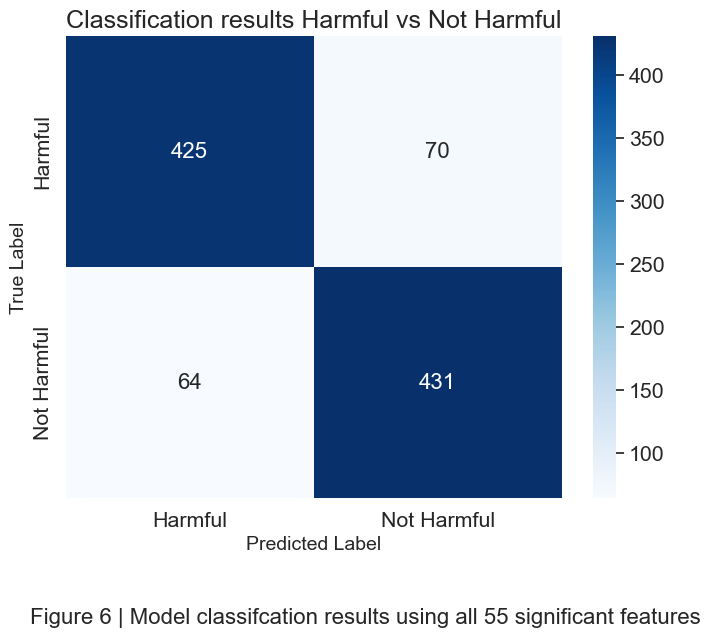

In [70]:
# CONFUSION MATRIX
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix data
data = np.array([[425, 70],
                 [64, 431]])
#
# Class labels
labels = ["Harmful", "Not Harmful"]

# Create a confusion matrix plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(data, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, annot_kws={"size": 16})

# Set the title and the caption
plt.title("Classification results Harmful vs Not Harmful", fontsize=18)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.figtext(0.5, -0.1, "Figure 6 | Model classifcation results using all 55 significant features", wrap=True, horizontalalignment='center', fontsize=16)

# Show the plot
plt.show()


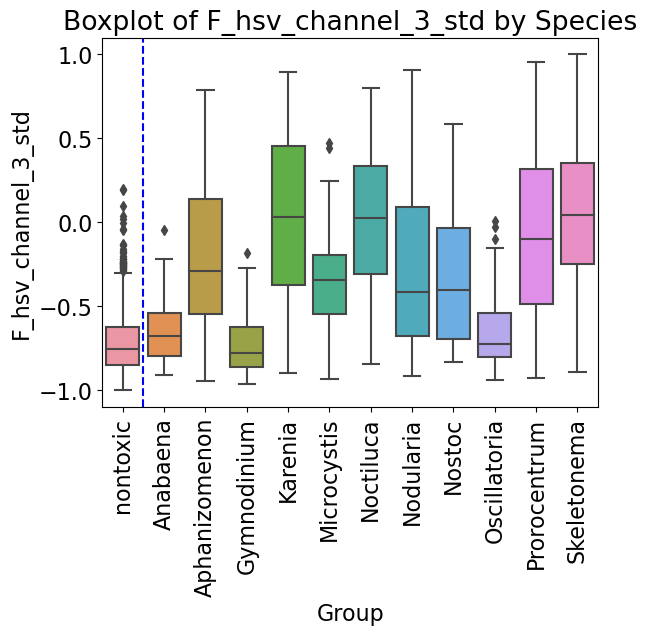

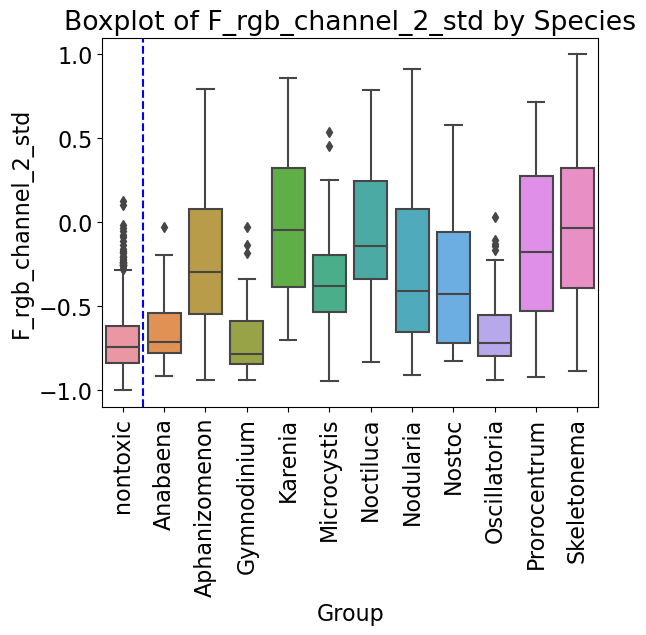

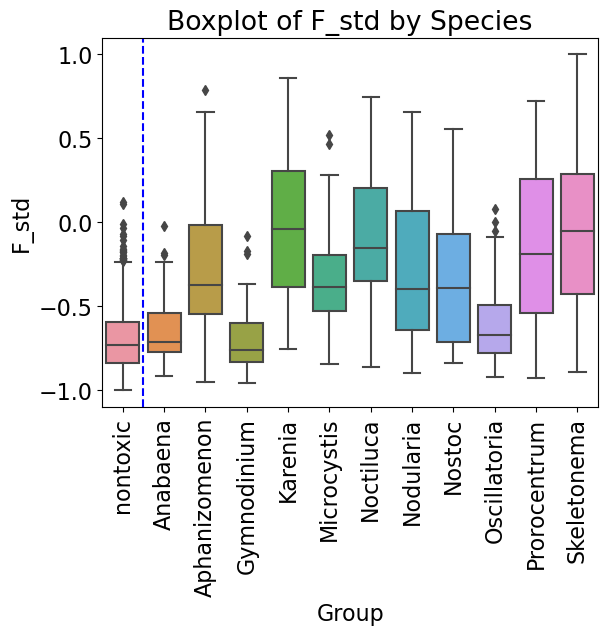

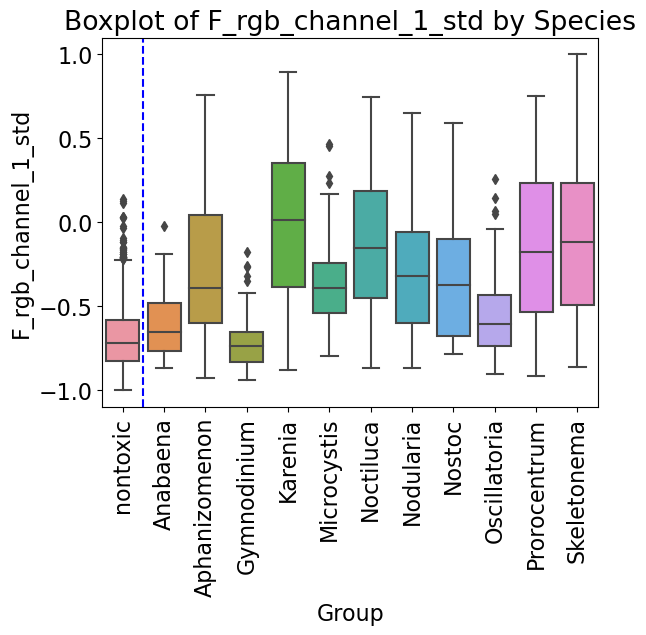

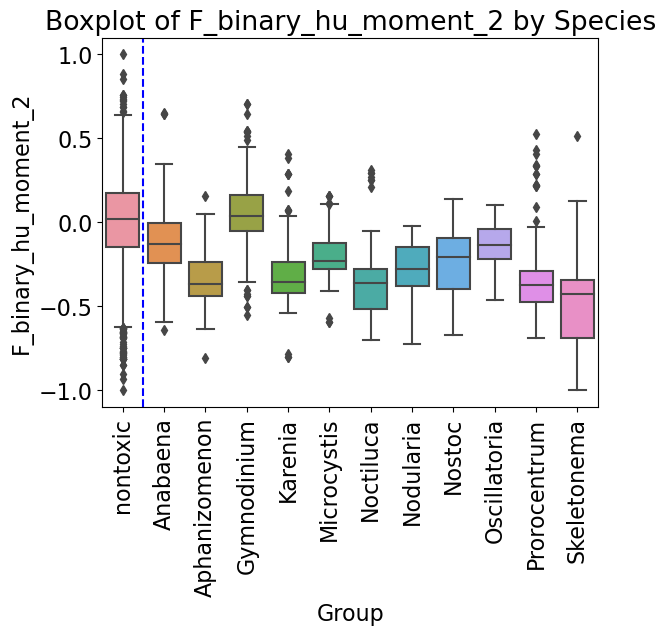

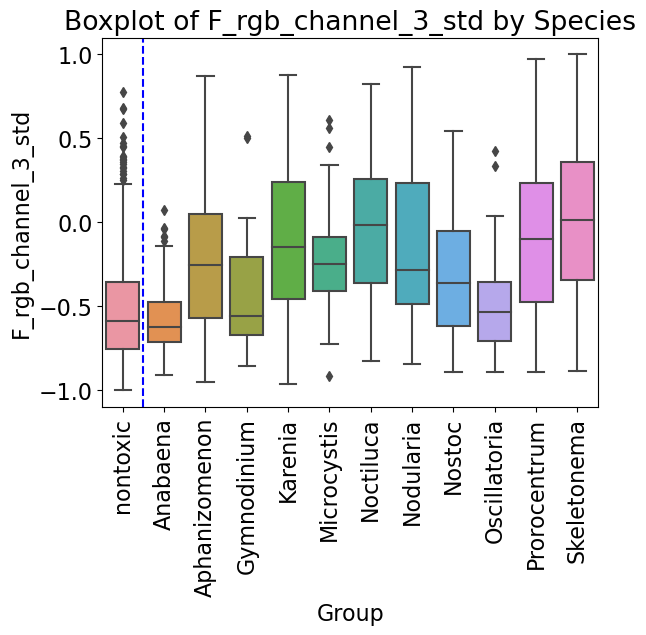

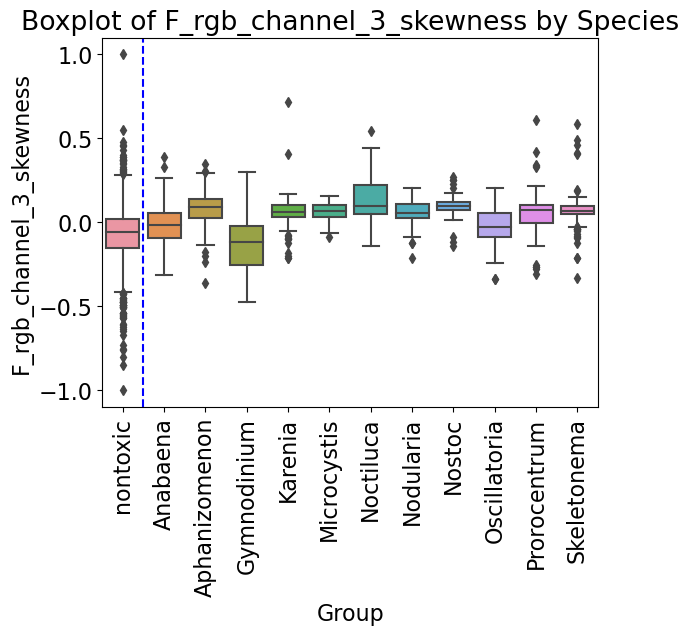

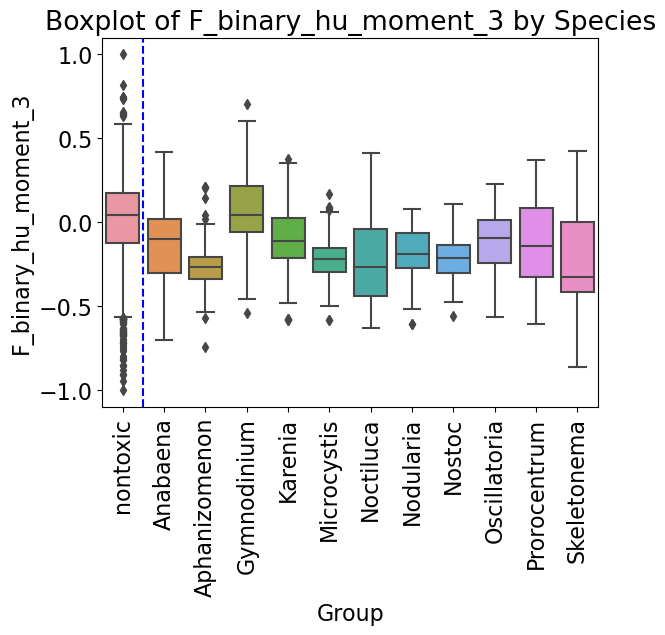

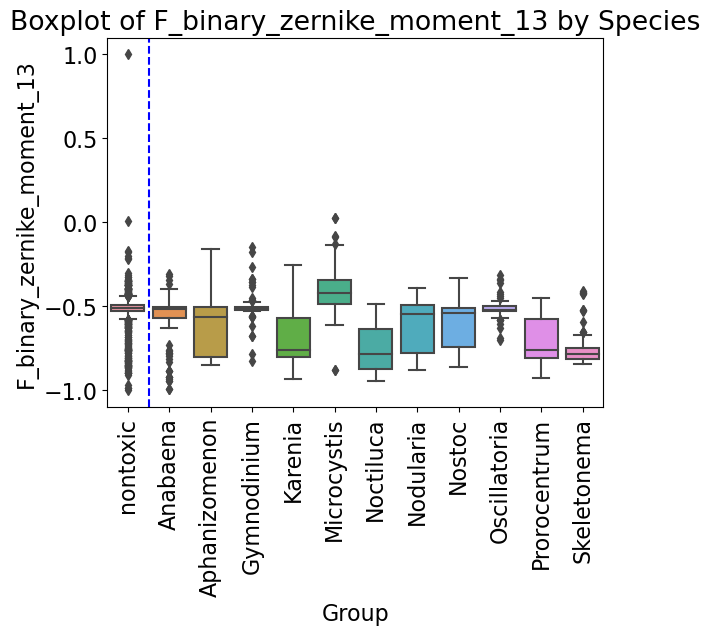

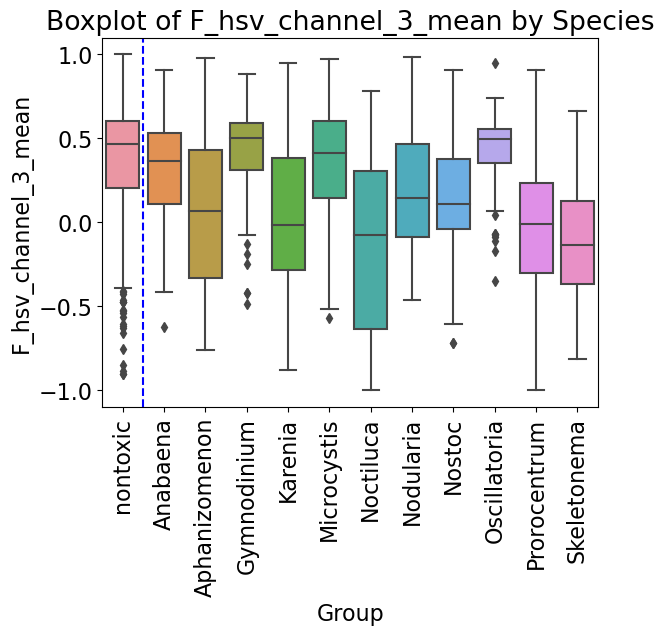

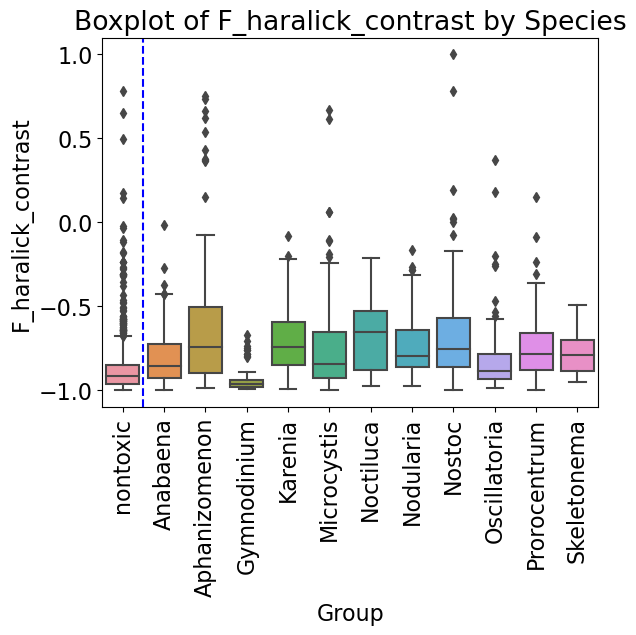

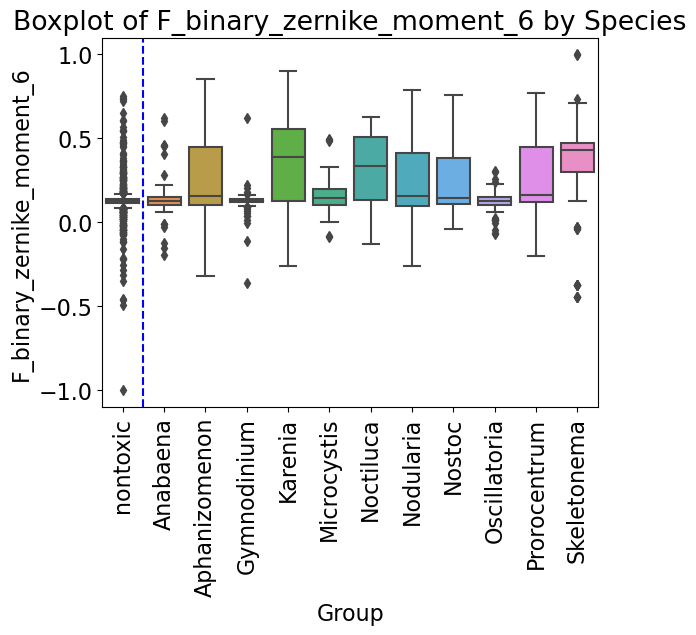

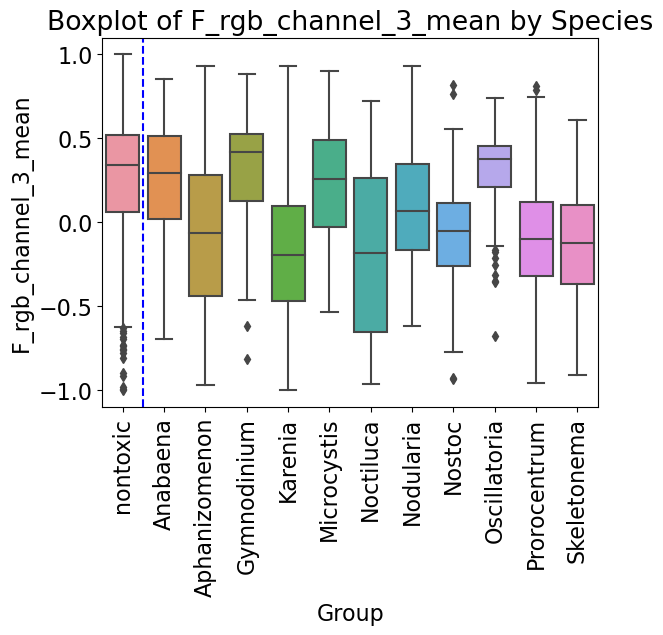

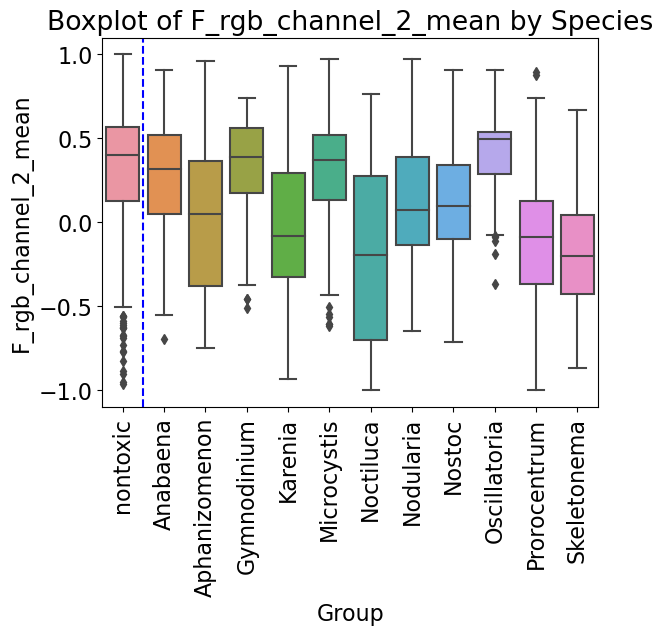

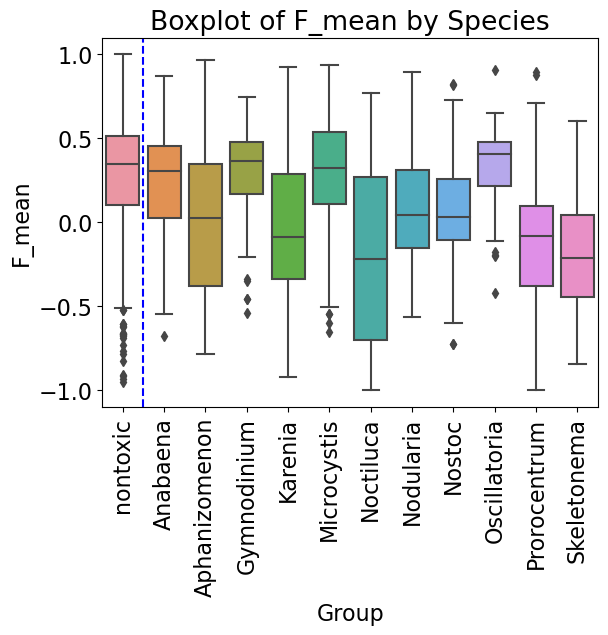

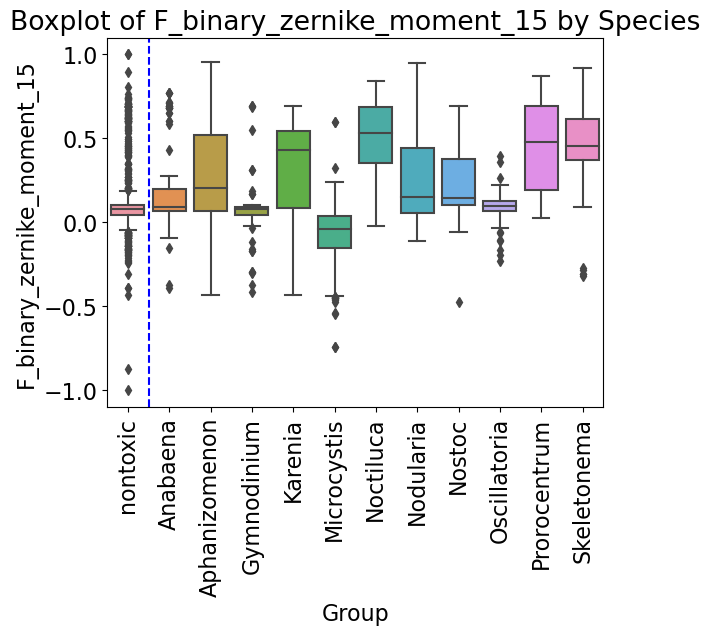

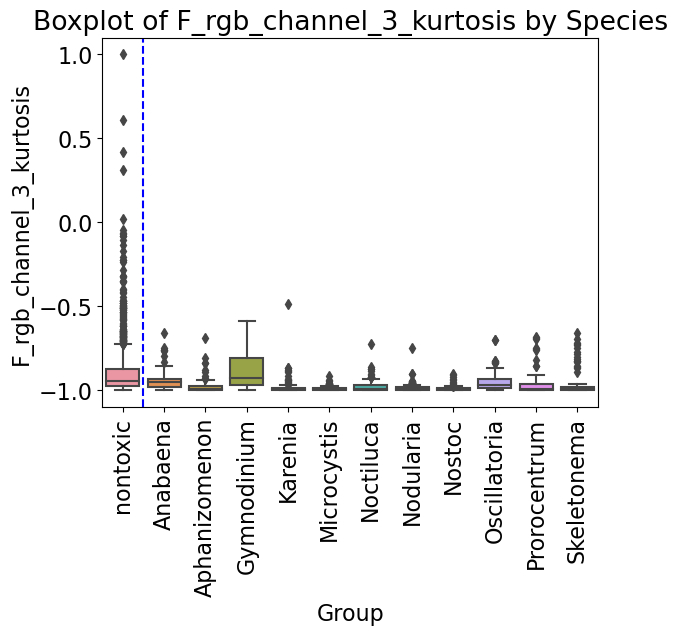

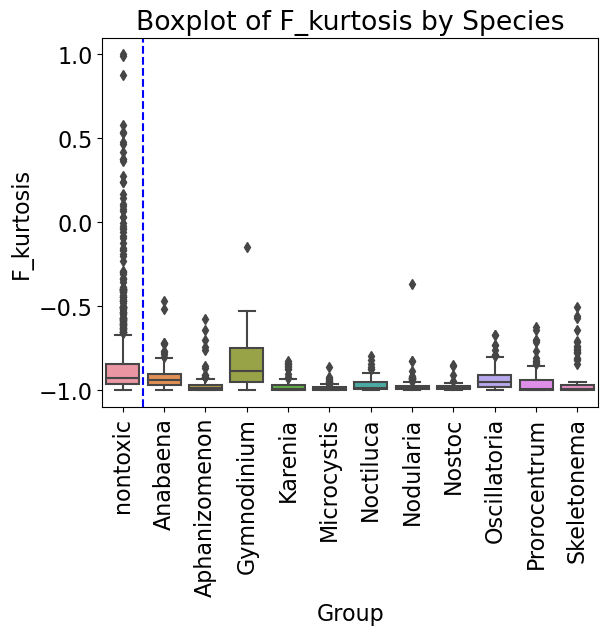

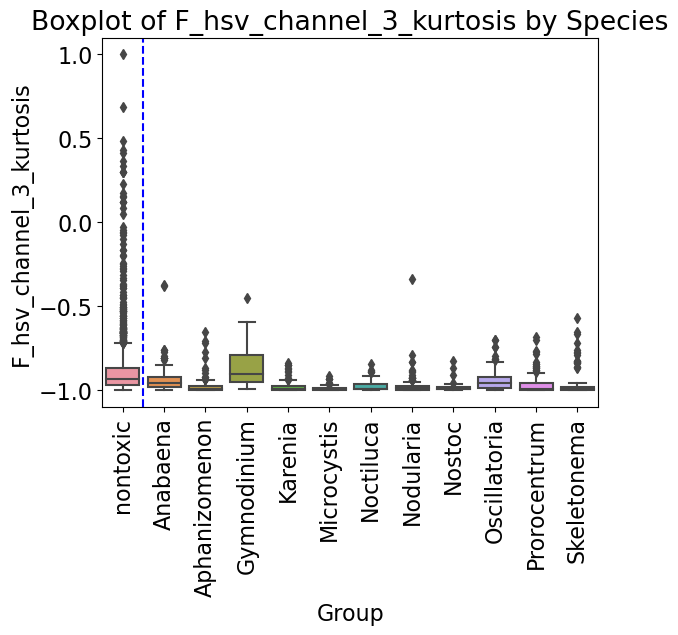

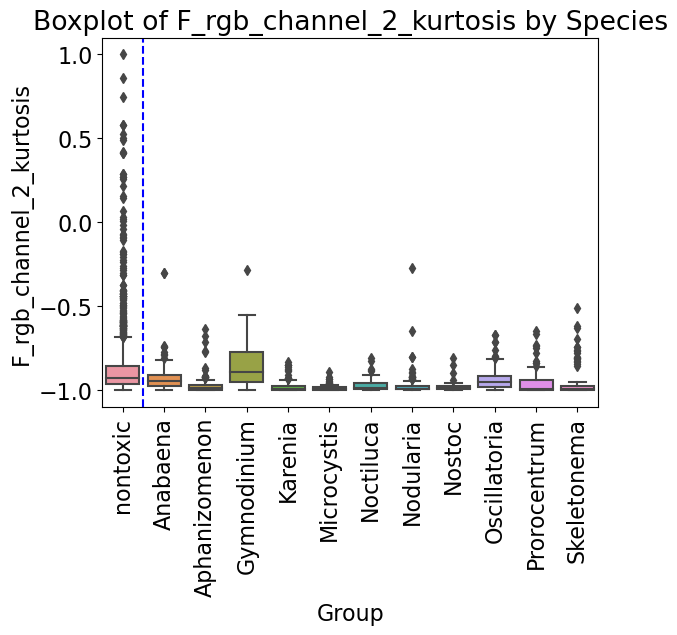

In [51]:
# BOXPLOTS FOR THE DIFFERENCE OF FEATURE VALUES FOR THE TWO CLASSES

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the train_df_significant_features DataFrame
stat_columns = features_columns_fdr_filtered

def generate_boxplots(group_by):
    stats_df = train_df_significant_features[stat_columns + [group_by]].rename(columns={group_by: 'Group'})

    unique_labels = sorted(stats_df['Group'].unique())
    if 'nontoxic' in unique_labels:
        unique_labels = sorted(unique_labels, key=lambda x: ('' if x == 'nontoxic' else x))

    for column in stat_columns:
        plt.figure()
        sns.boxplot(x='Group', y=column, data=stats_df, order=unique_labels)
        plt.title(f'Boxplot of {column} by {group_by.capitalize()}')

        if 'nontoxic' in unique_labels:
            nontoxic_index = unique_labels.index('nontoxic')
            plt.axvline(x=nontoxic_index + 0.5, color='b', linestyle='--')

        plt.xticks(rotation=90)
        plt.show()

generate_boxplots('species')  # Switch between 'label' and 'species' as needed


In [52]:
import pandas as pd

columns_to_copy = ['label', 'species', 'filename']

# Get the current number of columns in the arrays
num_columns = train_hcf_pca.shape[1]

# Create column names for the existing columns in the arrays
column_names = [f'PC{i+1}' for i in range(num_columns)]

train_hcf_pca_df = pd.DataFrame(train_hcf_pca, columns=column_names)


for col in columns_to_copy:
    train_hcf_pca_df[col] = train_df_significant_features[col].values


# Get the current number of columns in the arrays
num_columns = train_surf_pca.shape[1]

# Create column names for the existing columns in the arrays
column_names = [f'PC{i+1}' for i in range(num_columns)]

train_surf_pca_df = pd.DataFrame(train_surf_pca, columns=column_names)

for col in columns_to_copy:
    train_surf_pca_df[col] = predTable_train[col].values



In [53]:
train_surf_pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7       PC8       PC9      PC10      PC11      PC12      PC13      PC14      PC15      PC16      PC17      PC18      PC19      PC20      PC21      PC22      PC23      PC24      PC25      PC26      PC27      PC28      PC29      PC30      PC31      PC32      PC33      PC34      PC35      PC36      PC37      PC38      PC39      PC40      PC41      PC42      PC43      PC44      PC45      PC46      PC47      PC48      PC49      PC50      PC51      PC52      PC53      PC54      PC55      PC56      PC57      PC58      PC59      PC60      PC61      PC62      PC63      PC64      PC65      PC66      PC67      PC68      PC69      PC70      PC71      PC72      PC73      PC74      PC75      PC76      PC77      PC78      PC79      PC80      PC81      PC82      PC83      PC84      PC85      PC86      PC87      PC88      PC89      PC90      PC91      PC92      PC93      PC94      PC95      PC96      PC97      PC98      PC99     PC100     PC101     PC102     PC103     PC104     PC105     PC106     PC107     PC108     PC109     PC110     PC111     PC112     PC113     PC114     PC115     PC116     PC117     PC118     PC119     PC120     PC121     PC122     PC123     PC124     PC125     PC126     PC127     PC128     PC129     PC130     PC131     PC132     PC133     PC134     PC135     PC136     PC137     PC138     PC139     PC140     PC141     PC142     PC143     PC144     PC145     PC146     PC147     PC148     PC149     PC150     PC151     PC152     PC153     PC154     PC155     PC156     PC157     PC158     PC159     PC160     PC161     PC162     PC163     PC164     PC165     PC166     PC167     PC168     PC169     PC170     PC171     PC172     PC173     PC174     PC175     PC176     PC177     PC178     PC179     PC180     PC181     PC182     PC183     PC184     PC185     PC186     PC187     PC188     PC189     PC190     PC191     PC192     PC193     PC194     PC195     PC196     PC197     PC198     PC199     PC200     PC201     PC202     PC203     PC204     PC205     PC206     PC207     PC208     PC209     PC210     PC211     PC212     PC213     PC214     PC215     PC216     PC217     PC218     PC219     PC220     PC221     PC222     PC223     PC224     PC225     PC226     PC227     PC228     PC229     PC230     PC231     PC232     PC233     PC234     PC235     PC236     PC237     PC238     PC239     PC240     PC241     PC242     PC243     PC244     PC245     PC246     PC247     PC248     PC249     PC250     PC251     PC252     PC253     PC254     PC255     PC256     PC257     PC258     PC259     PC260     PC261     PC262     PC263     PC264     PC265     PC266     PC267     PC268     PC269     PC270     PC271     PC272     PC273     PC274     PC275     PC276     PC277     PC278     PC279     PC280     PC281     PC282     PC283     PC284     PC285     PC286     PC287     PC288     PC289     PC290     PC291     PC292     PC293     PC294     PC295     PC296     PC297     PC298     PC299     PC300     PC301     PC302     PC303     PC304     PC305     PC306     PC307     PC308     PC309     PC310     PC311     PC312     PC313     PC314     PC315     PC316     PC317     PC318     PC319     PC320     PC321     PC322     PC323     PC324     PC325     PC326     PC327     PC328     PC329     PC330     PC331     PC332     PC333     PC334     PC335     PC336     PC337     PC338     PC339     PC340     PC341     PC342     PC343     PC344     PC345     PC346     PC347     PC348     PC349     PC350     PC351     PC352     PC353     PC354     PC355     PC356     PC357     PC358     PC359     PC360     PC361     PC362     PC363     PC364     PC365     PC366     PC367     PC368     PC369     PC370     PC371     PC372     PC373     PC374     PC375     PC376     PC377     PC378     PC379     PC380     PC381     PC382     PC383     PC384     PC385     PC386     PC387     PC388     PC389     PC390     PC391     PC392     PC393     PC394     PC395     PC396     PC397     PC398     PC399     PC400     PC

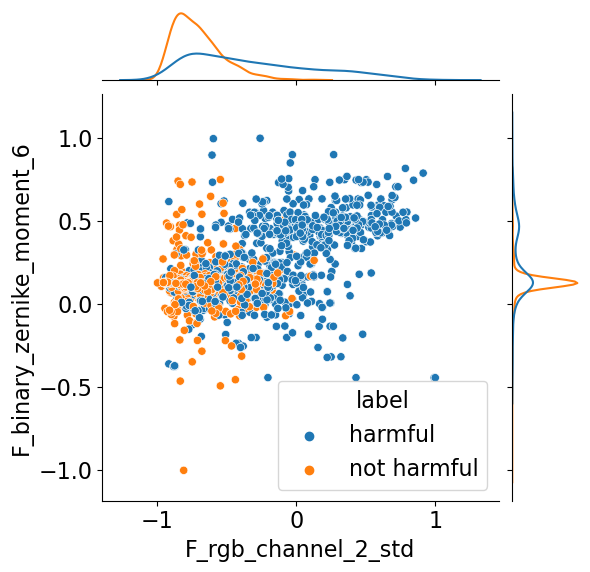

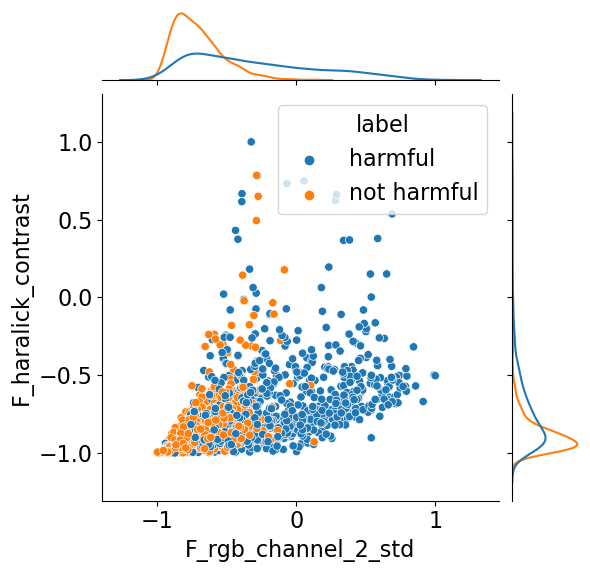

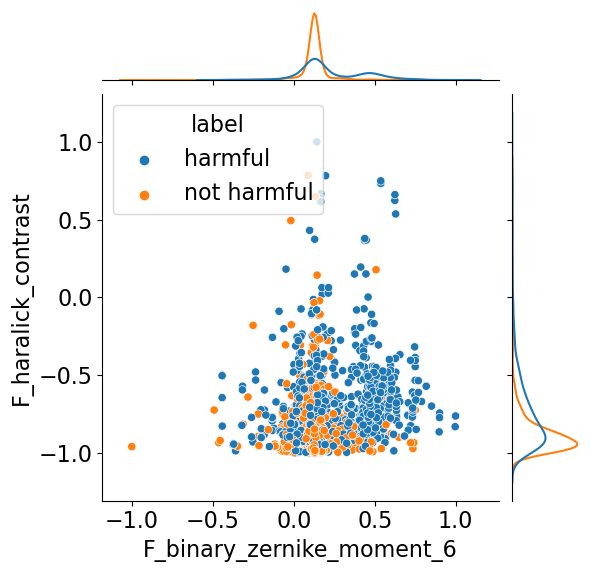

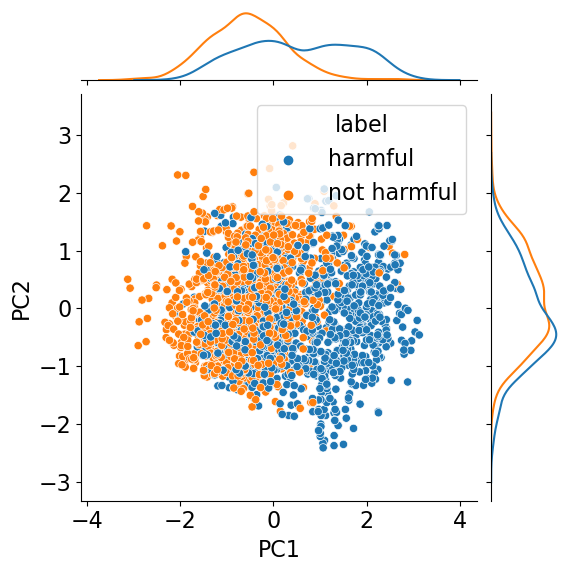

In [58]:
# JOINT AND MARGINAL DENSITY PLOTS

import seaborn as sns
import matplotlib.pyplot as plt

# Define feature names
feature_1 = 'F_rgb_channel_2_std'
feature_2 = 'F_binary_zernike_moment_6'
feature_3 = 'F_haralick_contrast'
feature_4 = 'PC1'
feature_5 = 'PC2'

# Create JointGrid scatter plots with marginal densities
def create_jointgrid_scatterplot(x, y, data, hue):
    g = sns.JointGrid(data=data, x=x, y=y)
    sns.scatterplot(data=data, x=x, y=y, hue=hue, ax=g.ax_joint)
    sns.kdeplot(data=data, x=x, hue=hue, common_norm=False, ax=g.ax_marg_x, legend=False)
    sns.kdeplot(data=data, y=y, hue=hue, common_norm=False, ax=g.ax_marg_y, legend=False)
    return g

# Plot scatter plots for feature pairs
create_jointgrid_scatterplot(feature_1, feature_2, train_df_significant_features, 'label')
create_jointgrid_scatterplot(feature_1, feature_3, train_df_significant_features, 'label')
create_jointgrid_scatterplot(feature_2, feature_3, train_df_significant_features, 'label')
create_jointgrid_scatterplot(feature_4, feature_5, train_hcf_pca_df, 'label')

# Display plots
plt.show()
